# **Analyzing Cleantech Media Data with NLP Techniques** (Maha)

This notebook demonstrates the process of loading, cleaning, tokenizing, and analyzing a Cleantech media dataset using various natural language processing (NLP) techniques, including word embeddings, machine learning classification models, and sentence embeddings. We will explore how to extract meaningful insights from textual data in the field of clean technology.



## **Library Imports and Setup**

In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
import spacy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, pairwise as cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import Counter
from sentence_transformers import SentenceTransformer
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.downloader import load
import gensim.downloader as api
from nltk.tokenize import word_tokenize
from spacy.lang.en import English

import random
import sklearn.metrics as metrics

nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/maha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CLT/

## **Load the Dataset**

Load the dataset and inspect the first few entries.

In [ ]:
# Load the dataset
file_path = '/Users/maha/Desktop/NLP/cleantech_media_dataset_cleaned.csv'
media_data = pd.read_csv(file_path)

In [ ]:
# Inspect the data frame
media_data.dropna(subset=['content_preprocessed'], inplace=True)  # Make sure to drop rows where the content is NaN
print(media_data[['title', 'content_preprocessed']].head(10))

## **Data Preparation for Embeddings**

Define a function to preprocess the text data and apply it to the dataset. Tokenize the text using SpaCy.



In [ ]:
# Function to preprocess the text data
def preprocess_text(text):
    text = re.sub(r'<.*?>', ' ', text)  # Remove HTML tags
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)
    stop_words = set(nltk.corpus.stopwords.words('english'))
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing
media_data['clean_text'] = media_data['content_preprocessed'].apply(preprocess_text)

# Initialize Spacy's English tokenizer with disabled components for efficiency
nlp = English(disable=['tagger', 'parser', 'ner'])

# Tokenize the cleaned text
def tokenize(text):
    doc = nlp(text)
    return [token.text for token in doc]

media_data['tokens'] = media_data['clean_text'].apply(tokenize)

# Display the first few rows to check the preprocessed and tokenized data
print(media_data[['clean_text', 'tokens']].head())

                                          clean_text  \
0  qatar petroleum qp targeting aggressive cut gr...   
1  nuclear power corp india ltd npcil synchronize...   
2  new u president joe biden took office week usc...   
3  slow pace japanese reactor restarts continues ...   
4  two new york city largest pension fund say div...   

                                              tokens  
0  [qatar, petroleum, qp, targeting, aggressive, ...  
1  [nuclear, power, corp, india, ltd, npcil, sync...  
2  [new, u, president, joe, biden, took, office, ...  
3  [slow, pace, japanese, reactor, restarts, cont...  
4  [two, new, york, city, largest, pension, fund,...  


## **Word Embedding Training**
In this section, we will train separate word embedding models using techniques such as Word2Vec, FastText, and GloVe. These embeddings will serve as the basis for further analysis and comparison of thematic overlaps and differences.

## Word2Vec Embedding

In this section, we are going to set up and train a Word2Vec model using the Gensim library. This model will be able to learn how words are associated based on the context in which they appear in the text. Also, we will be experimenting with various hyperparameters like vector dimensions, context window size, and training epochs in order to fine-tune the ord embeddings.

In [ ]:
# Set values for various parameters of Word2Vec
feature_size = 100  # Word vector dimensionality
window_context = 5  # Context window size
min_word_count = 5  # Minimum word count
# Initialize and train the Word2Vec model
w2vmodel = Word2Vec(sentences=media_data['tokens'], vector_size=feature_size, window=window_context, min_count=min_word_count, sg=0)


### Compute cosine Similarity

In [ ]:
# This method computes cosine similarity between a simple mean of the projection weight vectors of the given words and the vectors for each word in the model.

w2vmodel.wv.most_similar('electricity', topn=5)

[('power', 0.6806957125663757),
 ('energy', 0.5664961934089661),
 ('excess', 0.5583328604698181),
 ('surplus', 0.5170078277587891),
 ('intermittent', 0.5111079812049866)]

In [ ]:
# Define a list of tuples where each tuple contains the relevant words for each topic
topics = [
    ('geothermal', 'exploration'),
    ('hydrogen', 'energy'),
    ('solar', 'renewable'),
    ('environmental', 'conservation'),
    ('battery', 'lithium')
]

# Iterate over each topic and calculate the similarity between the relevant words
for topic in topics:
    word1, word2 = topic
    similarity_score = w2vmodel.wv.similarity(word1, word2)
    print(f"Similarity between '{word1}' and '{word2}': {similarity_score}")

Similarity between 'geothermal' and 'exploration': 0.3664986789226532
Similarity between 'hydrogen' and 'energy': 0.2958250045776367
Similarity between 'solar' and 'renewable': 0.43717288970947266
Similarity between 'environmental' and 'conservation': 0.5045112371444702
Similarity between 'battery' and 'lithium': 0.4051816463470459


In [ ]:
# View similar words based on gensim's model
similar_words = {
    search_term:
    [item[0] for item in w2vmodel.wv.most_similar([search_term], topn=5)]
    for search_term in ['offshore', 'wind', 'renewables', 'solar', 'energy', 'nuclear', 'investment', 'sustainable', 'environmental', 'gas']
}
similar_words

{'offshore': ['floating', 'onshore', 'vineyard', 'washingtonbased', 'turbine'],
 'wind': ['aurelia', 'aquafarming', 'windfarms', 'tidal', 'cppa'],
 'renewables': ['renewable', 'wind', 'government', 'carbonfree', 'zerocarbon'],
 'solar': ['photovoltaic',
  'utilityscale',
  'rooftop',
  'groundmount',
  'bifacial'],
 'energy': ['electricity',
  'power',
  'complement',
  'intermittent',
  'decentralized'],
 'nuclear': ['coal', 'coalfired', 'reactor', 'fusion', 'restarts'],
 'investment': ['invest', 'financing', 'spending', 'investing', 'funding'],
 'sustainable': ['greener',
  'cleaner',
  'climatefriendly',
  'friendly',
  'equitable'],
 'environmental': ['ecological',
  'intertwining',
  'environment',
  'conservation',
  'health'],
 'gas': ['crude', 'gasfired', 'gasbased', 'gasrelated', 'landcover']}

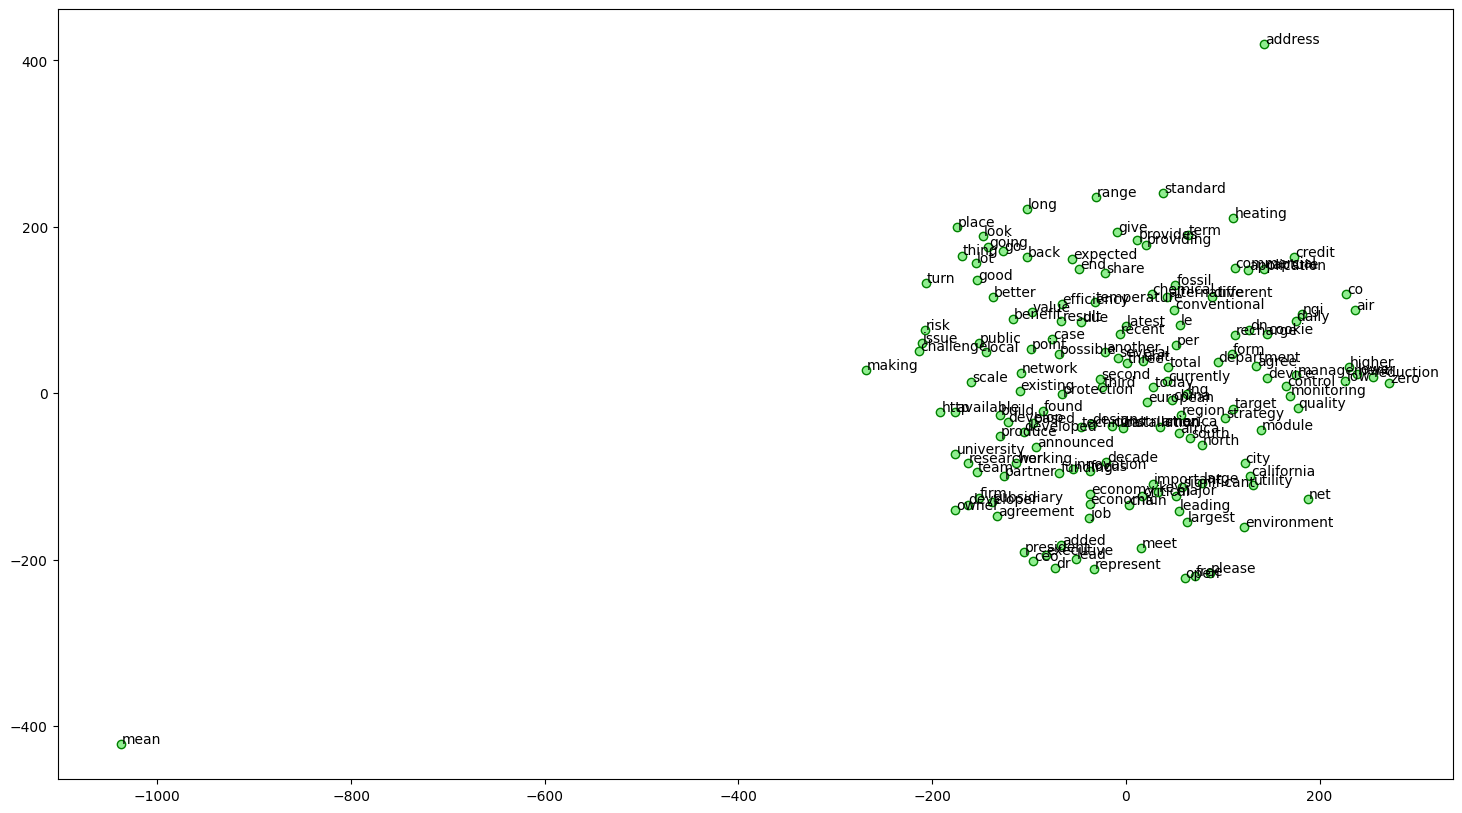

In [ ]:
# Visualise using Tsne
words = w2vmodel.wv.index_to_key[200:350]
wvs = w2vmodel.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')

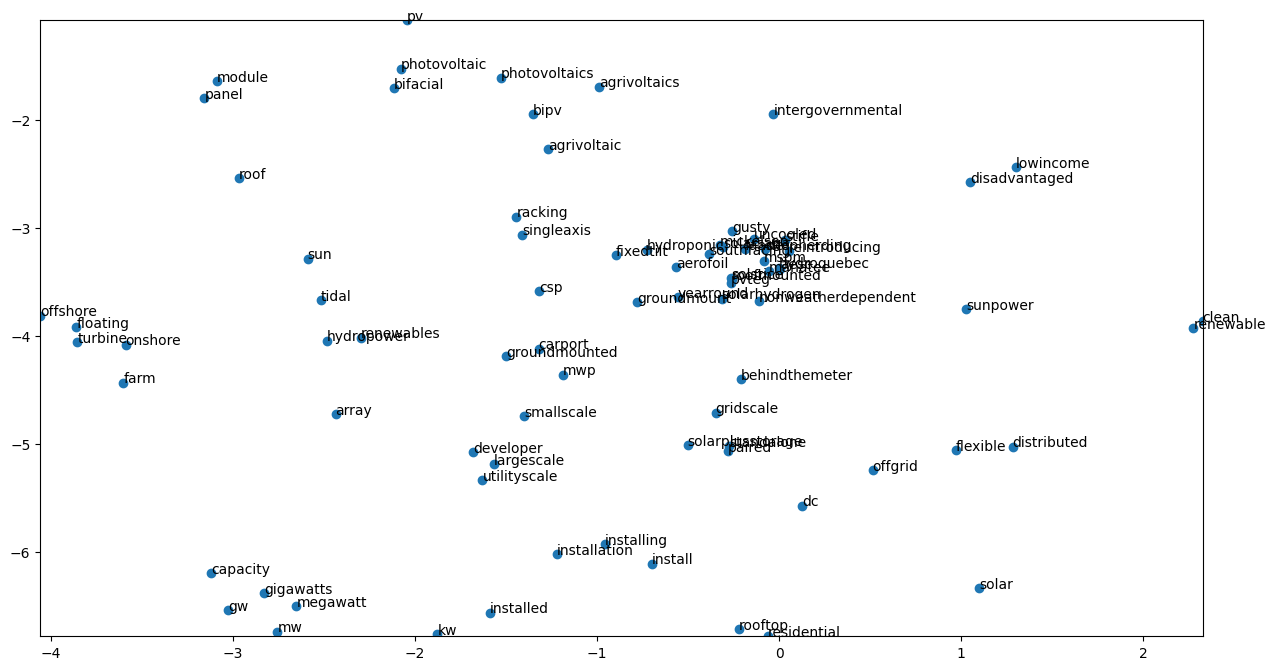

In [ ]:
# Select top similar words to a given token

def display_closestwords_tsnescatterplot(model, word, size):

    arr = np.empty((0,size), dtype='f')
    word_labels = [word]
    close_words = model.wv.similar_by_word(word, topn=80)
    arr = np.append(arr, np.array([model.wv[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)

    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.figure(figsize=(15, 8))
    plt.scatter(x_coords, y_coords)
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

    # Inspect the most similar and change the input token  to other tokens
display_closestwords_tsnescatterplot(w2vmodel, 'solar', 100)

### Hyperparameter for Word2Vec

In [ ]:
# Define a function to train Word2Vec model
def train_word2vec(tokens, vector_size, window, min_count, sg, epochs):
    model = Word2Vec(sentences=tokens, vector_size=vector_size, window=window, min_count=min_count, sg=sg, epochs=epochs)
    return model

# Define a function to evaluate Word2Vec model
def evaluate_word2vec_model(w2vmodel, word_pairs):
    similarities = []
    for word1, word2 in word_pairs:
        try:
            similarity = w2vmodel.wv.similarity(word1, word2)
            similarities.append(similarity)
        except KeyError:
            similarities.append(0)  # If the word is not in the vocabulary
    return similarities

# Define your tokens and word pairs for training and evaluation
tokens = media_data['tokens']  # Assuming 'media_data' contains the tokenized text
word_pairs = [
    ('solar', 'oil'),
    ('electric', 'fuel'),
    ('wind', 'turbine'),
    ('policy', 'change'),
    ('support', 'adaptation')
]


In [ ]:
# Define a set of hyperparameters to experiment with
vector_sizes = [100, 200]
window_sizes = [5, 10]
epochs_list = [10, 20]
sg_values = [0, 1]  # 0 for CBOW, 1 for skip-gram

best_score = 0
best_params = None
best_model = None

# Number of random combinations to try
n_combinations = 5

# Random search over the hyperparameters
for _ in range(n_combinations):
    vector_size = random.choice(vector_sizes)
    window = random.choice(window_sizes)
    epochs = random.choice(epochs_list)
    sg = random.choice(sg_values)

    print(f"Training Word2Vec model with vector_size={vector_size}, window={window}, epochs={epochs}, sg={sg}")
    w2vmodel = train_word2vec(tokens, vector_size, window, min_count=2, sg=sg, epochs=epochs)
    score = sum(evaluate_word2vec_model(w2vmodel, word_pairs)) / len(word_pairs)  # Average similarity
    print(f"Model score: {score}")

    if score > best_score:
        best_score = score
        best_params = (vector_size, window, epochs, sg)
        best_model = w2vmodel

# Retrain the model with the best parameters
if best_model:
    vector_size, window, epochs, sg = best_params
    best_model = Word2Vec(sentences=tokens, vector_size=vector_size, window=window, min_count=2, sg=sg, epochs=epochs)
    # Save the model to disk
    best_model.save("best_word2vec.model")
    print("Best model saved successfully.")

# Load the best Word2Vec model
best_word2vec_model = Word2Vec.load("best_word2vec.model")

# Evaluate the Word2Vec model
word2vec_similarities = evaluate_word2vec_model(best_word2vec_model, word_pairs)

# Create a DataFrame to store the results
results_word2vec = pd.DataFrame(word_pairs, columns=['Word1', 'Word2'])
results_word2vec['Similarity'] = word2vec_similarities

# Save the results to a CSV file
results_word2vec.to_csv("word2vec_results.csv", index=False)

# Display the results
print(results_word2vec)

Training Word2Vec model with vector_size=200, window=10, epochs=10, sg=0
Model score: 0.10905271768569946
Training Word2Vec model with vector_size=100, window=5, epochs=10, sg=1
Model score: 0.3522897005081177
Training Word2Vec model with vector_size=200, window=10, epochs=20, sg=1
Model score: 0.27821618020534516
Training Word2Vec model with vector_size=100, window=5, epochs=20, sg=1
Model score: 0.3666081041097641
Training Word2Vec model with vector_size=200, window=10, epochs=20, sg=0
Model score: 0.07791129127144814
Best model saved successfully.
      Word1       Word2  Similarity
0     solar         oil    0.116260
1  electric        fuel    0.284731
2      wind     turbine    0.725236
3    policy      change    0.311957
4   support  adaptation    0.294654


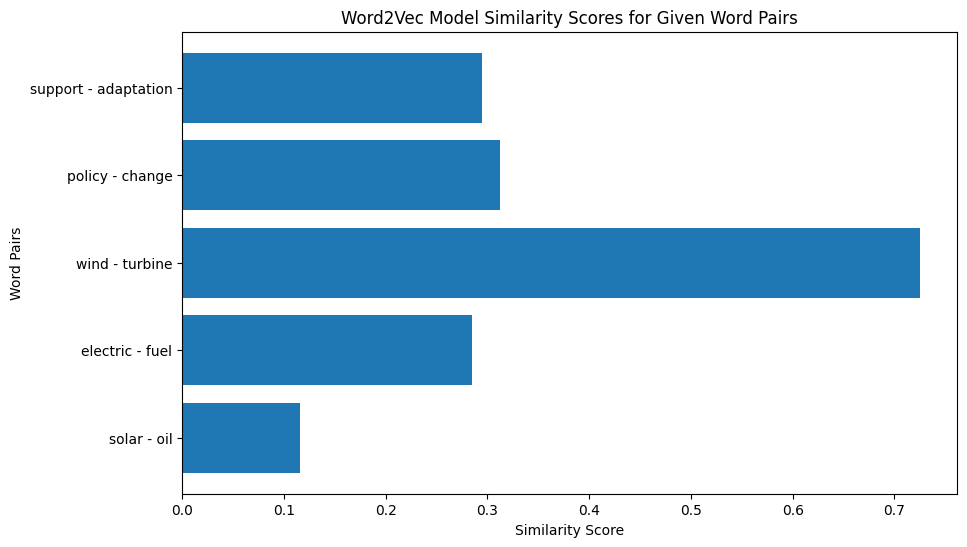

In [ ]:
# Visualize the results
plt.figure(figsize=(10, 6))
plt.barh(results_word2vec['Word1'] + ' - ' + results_word2vec['Word2'], results_word2vec['Similarity'], color='#1f77b4')
plt.xlabel('Similarity Score')
plt.ylabel('Word Pairs')
plt.title('Word2Vec Model Similarity Scores for Given Word Pairs')
plt.show()

####TSNE after using the hyperarameter

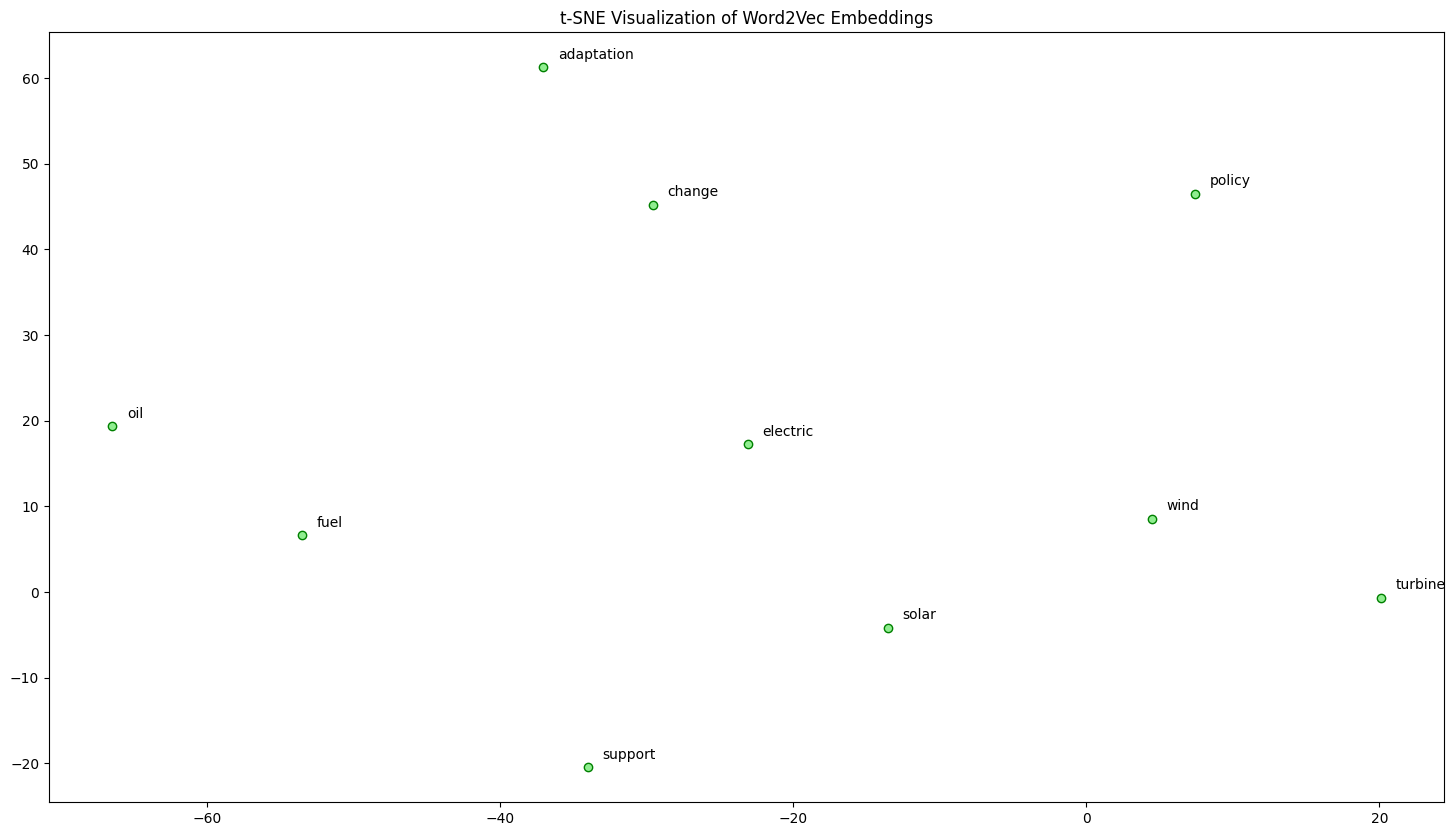

In [ ]:
# Load the best Word2Vec model
best_word2vec_model = Word2Vec.load("best_word2vec.model")

# Given word pairs for evaluation
word_pairs = [
    ('solar', 'oil'),
    ('electric', 'fuel'),
    ('wind', 'turbine'),
    ('policy', 'change'),
    ('support', 'adaptation')
]

# Flatten the list of word pairs to get a unique list of words
words = list(set([word for pair in word_pairs for word in pair]))

def get_word2vec_embeddings(model, words):
    embeddings = []
    for word in words:
        try:
            embeddings.append(model.wv[word])
        except KeyError:
            embeddings.append(np.zeros(model.vector_size))  # Handle OOV words
    return np.array(embeddings)

# Get Word2Vec embeddings for the specified words
word2vec_embeddings = get_word2vec_embeddings(best_word2vec_model, words)

# Apply t-SNE
tsne_model = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne_model.fit_transform(word2vec_embeddings)

# Plot t-SNE visualizations
plt.figure(figsize=(18, 10))
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(words, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x + 1, y + 1), xytext=(0, 0), textcoords='offset points')
plt.title("t-SNE Visualization of Word2Vec Embeddings")
plt.show()


## GloVe Embedding

GloVe (Global Vectors for Word Representation) is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.


In [ ]:
# GloVe Embedding
glove_vectors = load("glove-wiki-gigaword-100")

def evaluate_glove_model(model, word_pairs):
    similarities = []
    for word1, word2 in word_pairs:
        try:
            similarity = model.similarity(word1, word2)
            similarities.append(similarity)
        except KeyError:
            similarities.append(0)  # If the word is not in the vocabulary
    return similarities

# Given word pairs for evaluation
word_pairs = [
    ('solar', 'oil'),
    ('electric', 'fuel'),
    ('wind', 'turbine'),
    ('policy', 'change'),
    ('support', 'adaptation')
]

# Evaluate the GloVe model
glove_similarities = evaluate_glove_model(glove_vectors, word_pairs)

# Display the results
results_glove = pd.DataFrame(word_pairs, columns=['Word1', 'Word2'])
results_glove['Similarity'] = glove_similarities

# Save the results to a CSV file
results_glove.to_csv("glove_results.csv", index=False)

# Display the results
print(results_glove)


      Word1       Word2  Similarity
0     solar         oil    0.362699
1  electric        fuel    0.509705
2      wind     turbine    0.524926
3    policy      change    0.713463
4   support  adaptation    0.197887


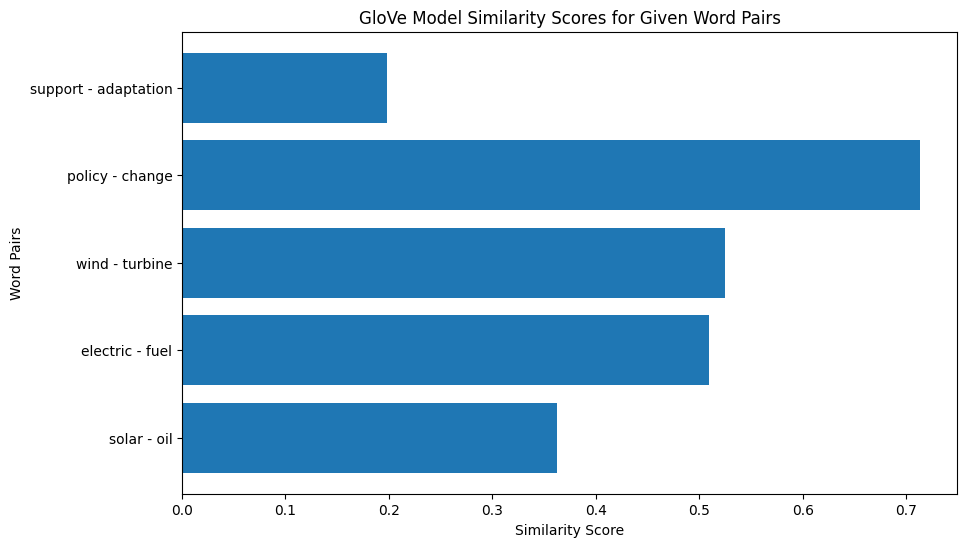

In [ ]:
# Visualize the results
plt.figure(figsize=(10, 6))
plt.barh(results_glove['Word1'] + ' - ' + results_glove['Word2'], results_glove['Similarity'], color='#1f77b4')
plt.xlabel('Similarity Score')
plt.ylabel('Word Pairs')
plt.title('GloVe Model Similarity Scores for Given Word Pairs')
plt.show()

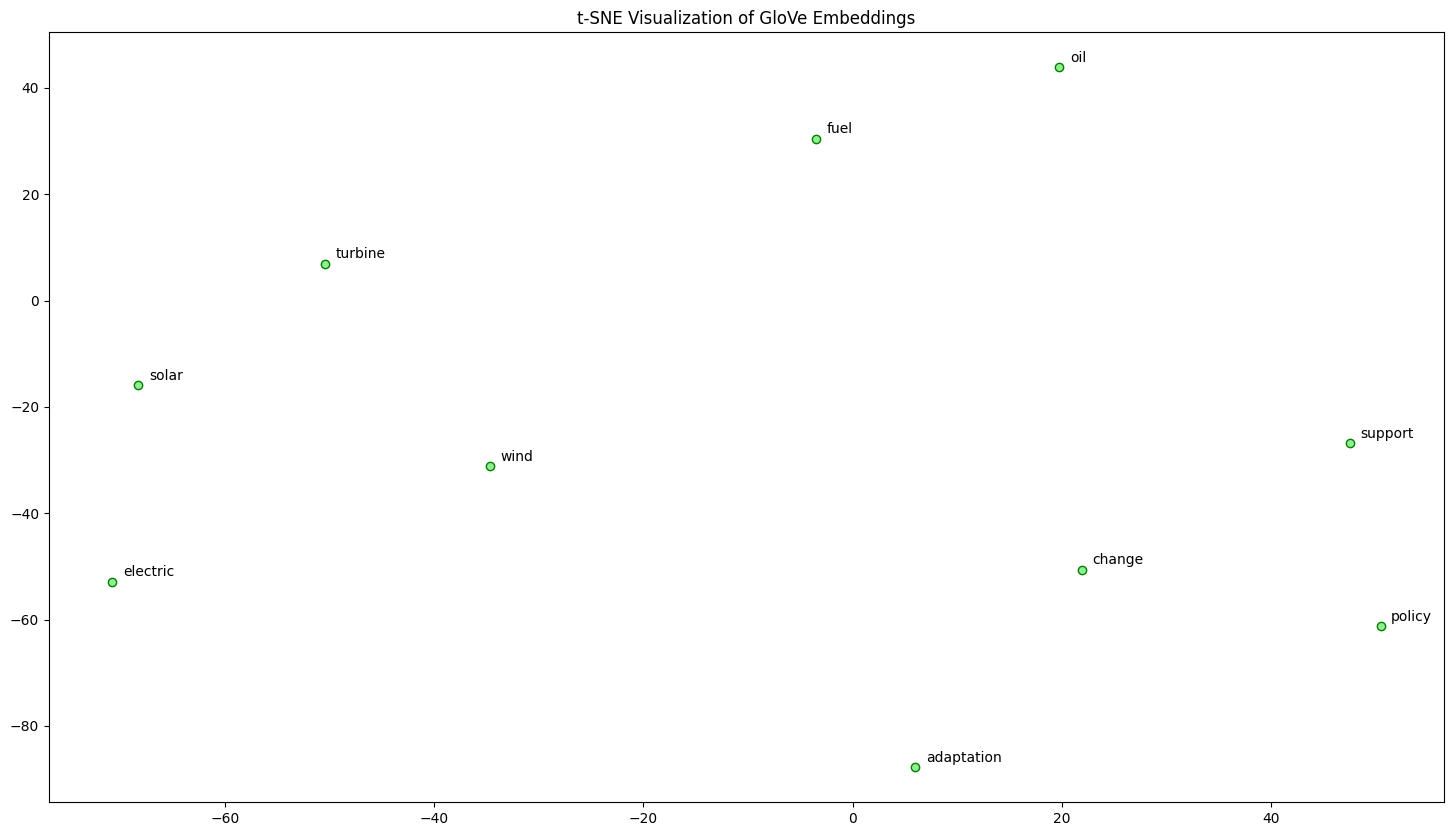

In [ ]:
# Load pre-trained GloVe model
glove_vectors = api.load("glove-wiki-gigaword-100")

# Given word pairs for evaluation
word_pairs = [
    ('solar', 'oil'),
    ('electric', 'fuel'),
    ('wind', 'turbine'),
    ('policy', 'change'),
    ('support', 'adaptation')
]

# Flatten the list of word pairs to get a unique list of words
words = list(set([word for pair in word_pairs for word in pair]))

def get_glove_embeddings(model, words):
    embeddings = []
    for word in words:
        try:
            embeddings.append(model[word])
        except KeyError:
            embeddings.append(np.zeros(model.vector_size))  # Handle OOV words
    return np.array(embeddings)

# Get GloVe embeddings for the specified words
glove_embeddings = get_glove_embeddings(glove_vectors, words)

# Apply t-SNE
tsne_model = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne_model.fit_transform(glove_embeddings)

# Plot t-SNE visualizations
plt.figure(figsize=(18, 10))
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(words, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x + 1, y + 1), xytext=(0, 0), textcoords='offset points')
plt.title("t-SNE Visualization of GloVe Embeddings")
plt.show()


## FastText Embeddings

FastText, developed by Facebook's AI Research (FAIR) lab, extends the Word2Vec model by representing each word as an n-gram of characters. This allows FastText to generate embeddings for words not seen during training by considering the character n-grams within the word.


In [ ]:
# Load pre-trained FastText model
fasttext_vectors = api.load('fasttext-wiki-news-subwords-300')

def evaluate_fasttext_model(model, word_pairs):
    similarities = []
    for word1, word2 in word_pairs:
        try:
            similarity = model.similarity(word1, word2)
            similarities.append(similarity)
        except KeyError:
            similarities.append(0)  # If the word is not in the vocabulary
    return similarities

# Evaluate the FastText model
fasttext_similarities = evaluate_fasttext_model(fasttext_vectors, word_pairs)

# Display the results
results_fasttext = pd.DataFrame(word_pairs, columns=['Word1', 'Word2'])
results_fasttext['Similarity'] = fasttext_similarities

# Save the results to a CSV file
results_fasttext.to_csv("fast_results.csv", index=False)

print(results_fasttext)

      Word1       Word2  Similarity
0     solar         oil    0.395517
1  electric        fuel    0.512126
2      wind     turbine    0.596275
3    policy      change    0.536397
4   support  adaptation    0.446131


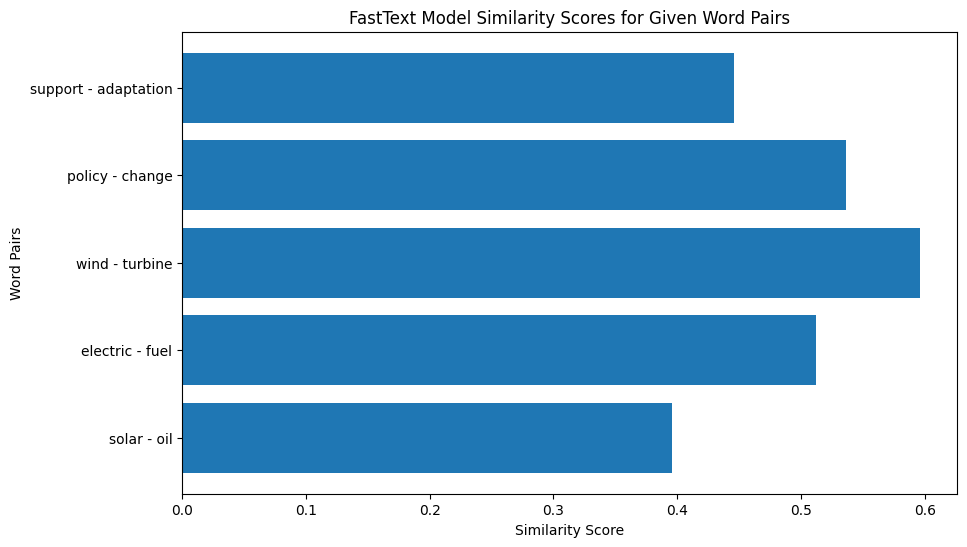

In [ ]:
# Visualize the results
plt.figure(figsize=(10, 6))
plt.barh(results_fasttext['Word1'] + ' - ' + results_fasttext['Word2'], results_fasttext['Similarity'], color='#1f77b4')
plt.xlabel('Similarity Score')
plt.ylabel('Word Pairs')
plt.title('FastText Model Similarity Scores for Given Word Pairs')
plt.show()

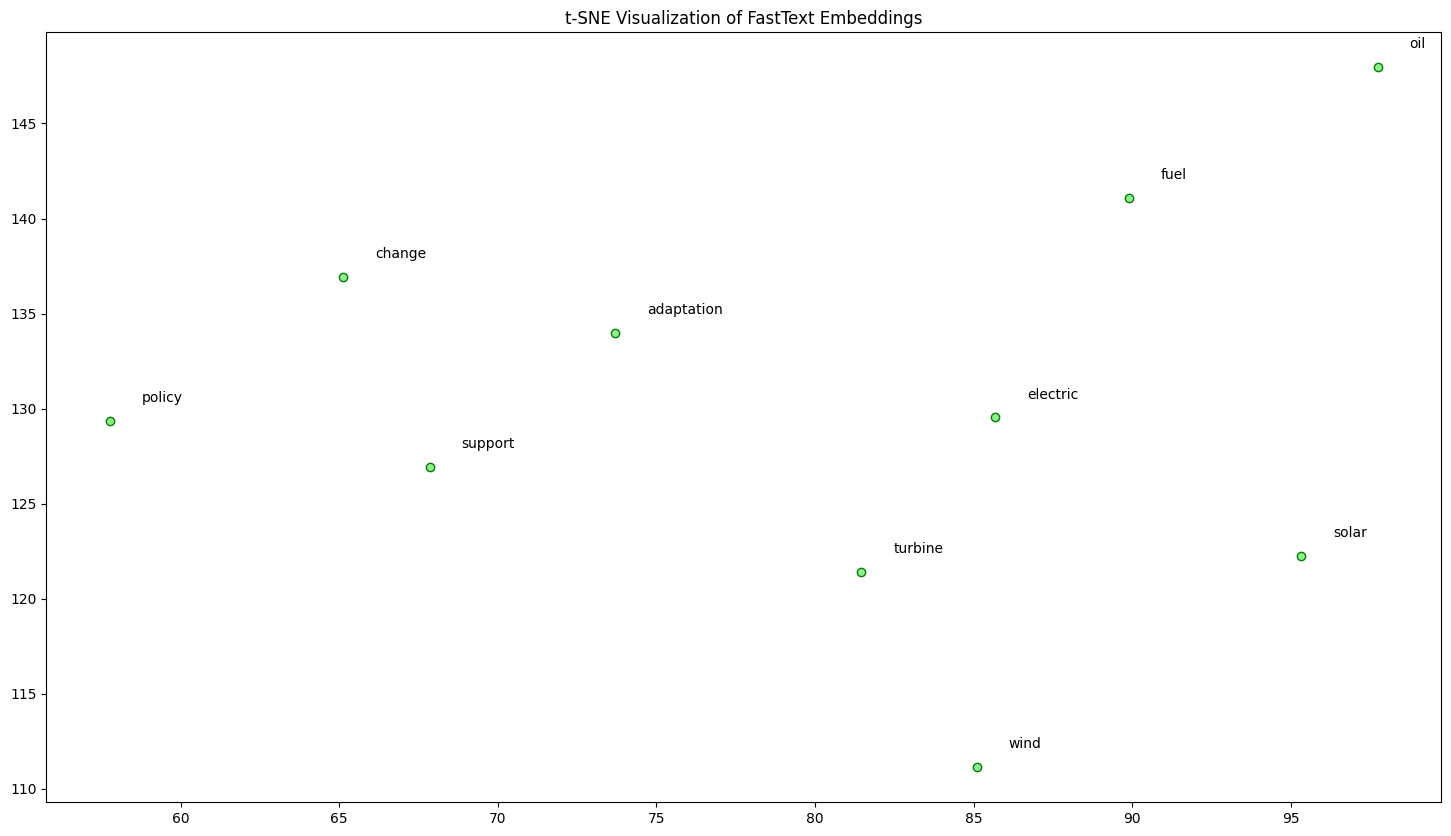

In [ ]:
# Load pre-trained FastText model
fasttext_vectors = api.load('fasttext-wiki-news-subwords-300')

# Given word pairs for evaluation
word_pairs = [
    ('solar', 'oil'),
    ('electric', 'fuel'),
    ('wind', 'turbine'),
    ('policy', 'change'),
    ('support', 'adaptation')
]

# Flatten the list of word pairs to get a unique list of words
words = list(set([word for pair in word_pairs for word in pair]))

def get_fasttext_embeddings(model, words):
    embeddings = []
    for word in words:
        try:
            embeddings.append(model[word])
        except KeyError:
            embeddings.append(np.zeros(model.vector_size))  # Handle OOV words
    return np.array(embeddings)

# Get FastText embeddings for the specified words
fasttext_embeddings = get_fasttext_embeddings(fasttext_vectors, words)

# Apply t-SNE
tsne_model = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne_model.fit_transform(fasttext_embeddings)

# Plot t-SNE visualizations
plt.figure(figsize=(18, 10))
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(words, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x + 1, y + 1), xytext=(0, 0), textcoords='offset points')
plt.title("t-SNE Visualization of FastText Embeddings")
plt.show()


## Visualization of Word Embeddings

Visualizing word embeddings helps us understand how different models capture the relationships between words. In this section, we will visualize the similarity scores of the best Word2Vec, GloVe, and FastText models to compare their performance.


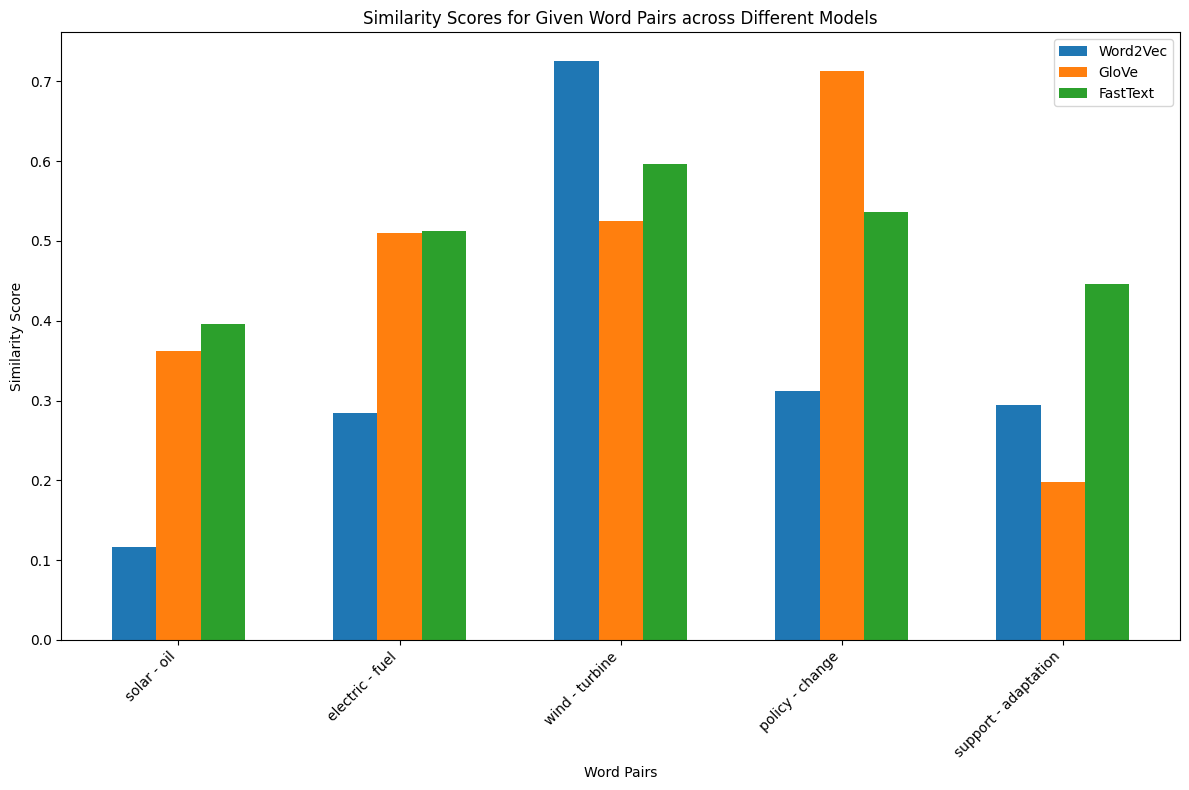

In [ ]:
# Combine the results
combined_results = results_word2vec.copy()
combined_results['GloVe Similarity'] = glove_similarities
combined_results['FastText Similarity'] = fasttext_similarities

# Plotting combined results
fig, ax = plt.subplots(figsize=(12, 8))
width = 0.2  # Bar width
x = np.arange(len(word_pairs))  # Label locations

bar1 = ax.bar(x - width, combined_results['Similarity'], width, label='Word2Vec', color='#1f77b4')
bar2 = ax.bar(x, combined_results['GloVe Similarity'], width, label='GloVe', color='#ff7f0e')
bar3 = ax.bar(x + width, combined_results['FastText Similarity'], width, label='FastText', color='#2ca02c')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Word Pairs')
ax.set_ylabel('Similarity Score')
ax.set_title('Similarity Scores for Given Word Pairs across Different Models')
ax.set_xticks(x)
ax.set_xticklabels([f"{pair[0]} - {pair[1]}" for pair in word_pairs], rotation=45, ha="right")
ax.legend()

plt.tight_layout()
plt.show()



## Word Analogy Tasks

In this section, we perform analogy tasks to evaluate the quality of the best Word2Vec, GloVe, and FastText models. Word analogy tasks are a common method to assess the semantic relationships captured by word embeddings. The task typically involves questions of the form "A is to B as C is to ?", which can be translated into a vector arithmetic problem: vec(B) - vec(A) + vec(C) ≈ vec(D).


In [ ]:
def perform_word_analogy(model, analogies):
    results = []
    for positive, negative in analogies:
        try:
            analogy_result = model.most_similar(positive=positive, negative=negative, topn=1)
            results.append((positive, negative, analogy_result))
        except KeyError as e:
            results.append((positive, negative, str(e)))
    return results

# Define domain-specific analogy tasks
analogies = [
    (['solar', 'energy'], ['wind']),
    (['electric', 'vehicle'], ['fuel']),
    (['renewable', 'energy'], ['fossil']),
    (['battery', 'storage'], ['fuel']),
    (['policy', 'change'], ['support'])
]


In [ ]:
# Perform analogy tasks with Word2Vec
word2vec_analogies = perform_word_analogy(best_model.wv, analogies)
print("Word2Vec Analogies:", word2vec_analogies)


Word2Vec Analogies: [(['solar', 'energy'], ['wind'], [('residential', 0.5261742472648621)]), (['electric', 'vehicle'], ['fuel'], [('ev', 0.5904666185379028)]), (['renewable', 'energy'], ['fossil'], [('crada', 0.592785656452179)]), (['battery', 'storage'], ['fuel'], [('queenslandbased', 0.6463219523429871)]), (['policy', 'change'], ['support'], [('climate', 0.6037035584449768)])]


In [ ]:
# Perform analogy tasks with GloVe
glove_analogies = perform_word_analogy(glove_vectors, analogies)
print("GloVe Analogies:", glove_analogies)

GloVe Analogies: [(['solar', 'energy'], ['wind'], [('renewable', 0.6825932264328003)]), (['electric', 'vehicle'], ['fuel'], [('motor', 0.6879421472549438)]), (['renewable', 'energy'], ['fossil'], [('electricity', 0.6250964403152466)]), (['battery', 'storage'], ['fuel'], [('batteries', 0.6163011193275452)]), (['policy', 'change'], ['support'], [('changes', 0.7110477089881897)])]


In [ ]:
# Perform analogy tasks with FastText
fasttext_analogies = perform_word_analogy(fasttext_vectors, analogies)
print("FastText Analogies:", fasttext_analogies)


FastText Analogies: [(['solar', 'energy'], ['wind'], [('energy-', 0.6925024390220642)]), (['electric', 'vehicle'], ['fuel'], [('electric-vehicle', 0.6457947492599487)]), (['renewable', 'energy'], ['fossil'], [('renewable-energy', 0.6291584968566895)]), (['battery', 'storage'], ['fuel'], [('batteries', 0.5852379202842712)]), (['policy', 'change'], ['support'], [('changes', 0.5972057580947876)])]


## Comparison of Model Performance: Word2Vec, GloVe, and FastText models

In this section, we will compare the performance of the Word2Vec, GloVe, and FastText models based on the similarity scores and analogy tasks. This comparison will help us understand the strengths and weaknesses of each model.


### Word Similarity Scores Comparison
This comparison will provide insights into how well each model captures semantic relationships between words.

In [ ]:
results_word2vec = pd.read_csv("word2vec_results.csv")
results_glove = pd.read_csv("glove_results.csv")
results_fasttext = pd.read_csv("fast_results.csv")

print("Word2Vec Results:")
print(results_word2vec.head())

print("\nGloVe Results:")
print(results_glove.head())

print("\nFastText Results:")
print(results_fasttext.head())


Word2Vec Results:
      Word1       Word2  Similarity
0     solar         oil    0.116260
1  electric        fuel    0.284731
2      wind     turbine    0.725236
3    policy      change    0.311957
4   support  adaptation    0.294654

GloVe Results:
      Word1       Word2  Similarity
0     solar         oil    0.362699
1  electric        fuel    0.509705
2      wind     turbine    0.524926
3    policy      change    0.713463
4   support  adaptation    0.197887

FastText Results:
      Word1       Word2  Similarity
0     solar         oil    0.395517
1  electric        fuel    0.512126
2      wind     turbine    0.596275
3    policy      change    0.536397
4   support  adaptation    0.446131


In [ ]:
# Calculate the average similarity scores for each model
avg_word2vec_similarity = results_word2vec['Similarity'].mean()
avg_glove_similarity = results_glove['Similarity'].mean()
avg_fasttext_similarity = results_fasttext['Similarity'].mean()

# Print the average similarity scores for each model
print("Average Word2Vec Similarity:", avg_word2vec_similarity)
print("Average GloVe Similarity:", avg_glove_similarity)
print("Average FastText Similarity:", avg_fasttext_similarity)

# Compare the models based on the average similarity scores
best_model = max([(avg_word2vec_similarity, 'Word2Vec'),
                  (avg_glove_similarity, 'GloVe'),
                  (avg_fasttext_similarity, 'FastText')], key=lambda x: x[0])

print("Best Model based on Average Similarity Score:", best_model[1])


Average Word2Vec Similarity: 0.346567462
Average GloVe Similarity: 0.46173585800000005
Average FastText Similarity: 0.497288964
Best Model based on Average Similarity Score: FastText


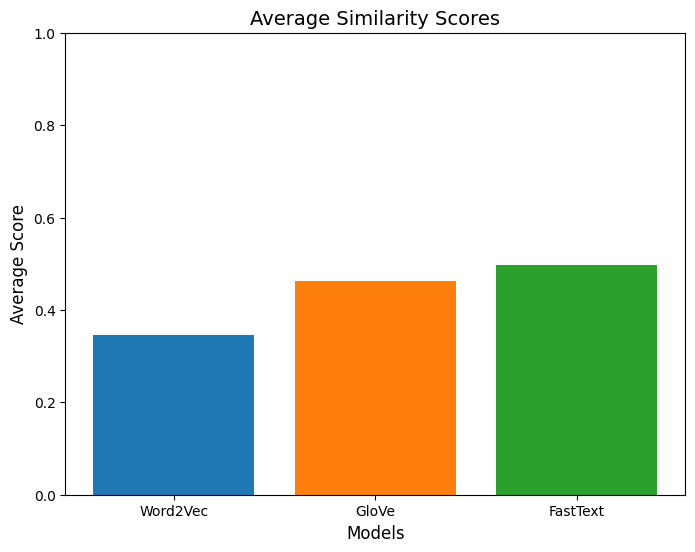

In [ ]:
# Model names and their corresponding average similarity scores
models = ['Word2Vec', 'GloVe', 'FastText']
avg_scores = [avg_word2vec_similarity, avg_glove_similarity, avg_fasttext_similarity]

# Define colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Create bar plot
plt.figure(figsize=(8, 6))
plt.bar(models, avg_scores, color=colors)
plt.title('Average Similarity Scores', fontsize=14)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Average Score', fontsize=12)
plt.ylim(0, 1)  # Adjust the y-axis limits if needed

# Display the plot
plt.show()


The average similarity scores provide insights into the performance of each word embedding model on the given similarity tasks.

- Average Word2Vec Similarity (0.346567462): This indicates the average similarity score achieved by the Word2Vec model across the word pairs evaluated. A lower average similarity score suggests that, on average, the Word2Vec model may not perform as well as GloVe or FastText in capturing semantic similarities between words.

- Average GloVe Similarity (0.461735858): This represents the average similarity score obtained by the GloVe model. GloVe performs better than Word2Vec with a higher average similarity score, indicating that it may be more effective in capturing semantic relationships between words.

- Average FastText Similarity (0.497288964): FastText achieves the highest average similarity score among the three models. This suggests that FastText performs the best on average in capturing semantic similarities between words compared to Word2Vec and GloVe.

Best Model based on Average Similarity Score:
- FastText: Based on the average similarity scores, FastText emerges as the best-performing model among Word2Vec, GloVe, and FastText. It consistently achieves the highest average similarity score, indicating its effectiveness in capturing semantic similarities between words in the given analogy tasks.

### Word Analogy Tasks comparison
 This comparison will help us understand the strengths and weaknesses of each model in capturing semantic and syntactic relationships between words.



In [ ]:
# Word2Vec Analogies
print("Word2Vec Analogies:", word2vec_analogies)

# GloVe Analogies
print("GloVe Analogies:", glove_analogies)

# FastText Analogies
print("FastText Analogies:", fasttext_analogies)


Word2Vec Analogies: [(['solar', 'energy'], ['wind'], [('residential', 0.5261742472648621)]), (['electric', 'vehicle'], ['fuel'], [('ev', 0.5904666185379028)]), (['renewable', 'energy'], ['fossil'], [('crada', 0.592785656452179)]), (['battery', 'storage'], ['fuel'], [('queenslandbased', 0.6463219523429871)]), (['policy', 'change'], ['support'], [('climate', 0.6037035584449768)])]
GloVe Analogies: [(['solar', 'energy'], ['wind'], [('renewable', 0.6825932264328003)]), (['electric', 'vehicle'], ['fuel'], [('motor', 0.6879421472549438)]), (['renewable', 'energy'], ['fossil'], [('electricity', 0.6250964403152466)]), (['battery', 'storage'], ['fuel'], [('batteries', 0.6163011193275452)]), (['policy', 'change'], ['support'], [('changes', 0.7110477089881897)])]
FastText Analogies: [(['solar', 'energy'], ['wind'], [('energy-', 0.6925024390220642)]), (['electric', 'vehicle'], ['fuel'], [('electric-vehicle', 0.6457947492599487)]), (['renewable', 'energy'], ['fossil'], [('renewable-energy', 0.62915

 When comparing the analogies generated by Word2Vec, GloVe, and FastText embeddings:

- Word2Vec: Produced mixed results with some relevant analogies but also some less intuitive ones.
- GloVe: Outperformed Word2Vec by providing more relevant analogies, demonstrating a better understanding of the relationships.
- FastText: Showed similar performance to GloVe, offering relevant analogies with terms that align well with the analogy relationships.

Overall, GloVe and FastText performed better than Word2Vec in generating relevant analogies.

## **Text Vectorization for Cleantech Media Data Analysis**
In this section, we will utilize text vectorization techniques on a dataset containing cleantech media articles. This will empower us to carry out various natural language processing (NLP) tasks, including sentiment analysis, topic modeling, and similarity analysis. The aim of this analysis is to prepare the Cleantech Media dataset for machine learning models by converting the textual content into numerical vectors using two popular methods: Bag of Words (BoW) and Term Frequency-Inverse Document Frequency (TF-IDF). These techniques transform text into numerical vectors that represent the significance of words or terms within the documents, allowing for effective feature extraction and subsequent model training.

## Creating train and validation sets

In [ ]:
# Splitting the dataset into Training and Testing Data
train_text, test_text = train_test_split(media_data['content_preprocessed'], test_size=0.3, random_state=42)


### Bag of Words (BoW)
The Bag of Words (BoW) model is a simple and commonly used text vectorization technique. It represents text data as a collectiongarding grammar and word order but keeping multiplicity. Each unique word in the text is represented by a binary or frequency-based feature in the resulting vector. of words, disrer.

In [ ]:
# Vectorization: Bag of Words
countVector = CountVectorizer(min_df=2)
trainFeatureSetBoW = countVector.fit_transform(train_text)
testFeatureSetBoW = countVector.transform(test_text)# Vectorization: TF-IDF
tfIdVector = TfidfVectorizer(min_df=6, norm='l2', smooth_idf=True, use_idf=True)
trainFeatureSetTfIdf = tfIdVector.fit_transform(train_text)
testFeatureSetTfIdf = tfIdVector.transform(test_text)

### Term Frequency-Inverse Document Frequency (TF-IDF).
Term Frequency-Inverse Document Frequency (TF-IDF) is a statistical measure used to evaluate the importance of a word in a document relative to a collection of documents. It balances the frequency of a word with how unique it is across all documents, helping to highlight significant words in the context of the entire corpus.

In [ ]:
# Vectorization: TF-IDF
tfIdVector = TfidfVectorizer(min_df=6, norm='l2', smooth_idf=True, use_idf=True)
trainFeatureSetTfIdf = tfIdVector.fit_transform(train_text)
testFeatureSetTfIdf = tfIdVector.transform(test_text)

##  Model Training and Evaluation

In this section, we will use sentence embeddings as features to train machine learning models. We will experiment with classifiers like SVM, Decision Trees, and Logistic Regression, and evaluate their performance using appropriate metrics.

In [ ]:
X = media_data['content_preprocessed']
y = media_data['domain']  # Using 'domain' as the label

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Create BoW features
countVector = CountVectorizer(min_df=2)
trainFeatureSet = countVector.fit_transform(X_train)
testFeatureSet = countVector.transform(X_test)


In [ ]:
# Extracting Features with TdIdf
tfIdVector = TfidfVectorizer(min_df=6, norm='l2', smooth_idf=True, use_idf=True)
tfidTrainFeatures = tfIdVector.fit_transform(X_train)
tfidTestFeatures = tfIdVector.transform(X_test)

### Support Vector Machine (SVM)

Support Vector Machines (SVM) are supervised learning models used for classification and regression analysis. They work by finding the hyperplane that best separates the classes in the feature space.

In [ ]:
# Initialize the SVM model
model_svm = svm.SVC(C=8.0, kernel='linear', probability=True)
model_svm.fit(trainFeatureSet, y_train)  # Fit the model on training data using BoW features

SVC(C=8.0, kernel='linear', probability=True)

In [ ]:
# Cross-validation
model_svm_acc = cross_val_score(estimator=model_svm, X=trainFeatureSet, y=y_train, cv=5, n_jobs=-1)

# Print cross-validation results
print("Cross-validation accuracies:", model_svm_acc)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation accuracies: [0.96416938 0.96026059 0.96286645 0.96807818 0.96023468]


In [ ]:
print("Mean accuracy:", model_svm_acc.mean())

Mean accuracy: 0.9631218546815081


The cross-validation results for the SVM model show a consistent performance across five different subsets of the training data, with individual accuracies ranging from about 96.02% to 96.81%, indicating a stable and reliable model. The mean accuracy of approximately 96.31% suggests that the model generalizes well to new, unseen data within the same distribution.

In [ ]:
# Making predictions on the test set
predicted = model_svm.predict(testFeatureSet)
print("Test set score:", model_svm.score(testFeatureSet, y_test))


Test set score: 0.969254820218864


The SVM model demonstrated strong performance on the test set with an accuracy of approximately 96.93%, indicating its robustness and effectiveness in classifying the Cleantech Media dataset.

In [ ]:
# Classification report
print(metrics.classification_report(y_test, predicted))

                       precision    recall  f1-score   support

         azocleantech       1.00      1.00      1.00       331
        businessgreen       0.81      0.64      0.71        33
        cleantechnica       1.00      1.00      1.00       382
            decarbxpo       1.00      1.00      1.00         1
            ecofriend       1.00      0.82      0.90        11
          energyintel       0.87      0.77      0.82        52
          energyvoice       0.86      0.93      0.89       204
            eurosolar       1.00      1.00      1.00         5
         greenprophet       0.83      0.62      0.71         8
      naturalgasintel       1.00      1.00      1.00       131
          pv-magazine       1.00      1.00      1.00       236
              pv-tech       0.86      0.86      0.86        43
         rechargenews       1.00      1.00      1.00       115
     solarindustrymag       1.00      0.99      1.00       131
  solarpowerportal.co       1.00      0.75      0.86  

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  


The SVM classification report for the Cleantech Media dataset shows an overall high accuracy of 97%, with excellent results in several categories like "azocleantech" and "cleantechnica." However, some categories like "solarquarter" have lower scores, and there were warnings about zero precision in infrequent classes, indicating that these areas might benefit from further model tuning or more data.

## Decision Tree

Decision Trees are a type of supervised learning algorithm used for classification and regression tasks. They work by splitting the data into subsets based on the value of input features, creating a tree-like model of decisions.



In [ ]:
# Initialize the Decision Tree model
model_dec = DecisionTreeClassifier(max_depth=10, random_state=0)
model_dec.fit(trainFeatureSet, y_train)  # Fit the model on training data using BoW features

DecisionTreeClassifier(max_depth=10, random_state=0)

In [ ]:
# Making predictions on the test set
predicted = model_dec.predict(testFeatureSet)
print("Test set score:", model_dec.score(testFeatureSet, y_test))


Test set score: 0.9390307451797811


In [ ]:
# Classification report
print(metrics.classification_report(y_test, predicted))

                       precision    recall  f1-score   support

         azocleantech       1.00      1.00      1.00       331
        businessgreen       0.00      0.00      0.00        33
        cleantechnica       1.00      1.00      1.00       382
            decarbxpo       0.00      0.00      0.00         1
            ecofriend       0.00      0.00      0.00        11
          energyintel       0.72      0.56      0.63        52
          energyvoice       0.69      0.94      0.79       204
            eurosolar       0.00      0.00      0.00         5
         greenprophet       0.00      0.00      0.00         8
      naturalgasintel       1.00      1.00      1.00       131
          pv-magazine       1.00      1.00      1.00       236
              pv-tech       0.74      0.91      0.81        43
         rechargenews       1.00      0.99      1.00       115
     solarindustrymag       1.00      0.99      1.00       131
  solarpowerportal.co       1.00      0.17      0.29  

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

## Naive Bayes

Naive Bayes is a family of simple yet effective probabilistic classifiers based on Bayes' Theorem with the assumption of feature independence. It is used in this context to classify cleantech media articles by leveraging the probabilistic relationships between features in the sentence embeddings.


In [ ]:
# Initialize the Gaussian Naive Bayes model
model_gnb = GaussianNB()
model_gnb.fit(trainFeatureSet.toarray(), y_train)  # Fit the model on training data using BoW features

GaussianNB()

In [ ]:
# Cross-validation
model_gnb_acc = cross_val_score(estimator=model_gnb, X=trainFeatureSet.toarray(), y=y_train, cv=5, n_jobs=-1)
print("Cross-validation accuracies:", model_gnb_acc)
print("Mean accuracy:", model_gnb_acc.mean())

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation accuracies: [0.75504886 0.7465798  0.75439739 0.75374593 0.76140808]
Mean accuracy: 0.7542360140825332


In [ ]:
# Cross-validation
model_gnb_acc = cross_val_score(estimator=model_gnb, X=trainFeatureSet.toarray(), y=y_train, cv=5, n_jobs=-1)
print("Cross-validation accuracies:", model_gnb_acc)
print("Mean accuracy:", model_gnb_acc.mean())

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation accuracies: [0.75504886 0.7465798  0.75439739 0.75374593 0.76140808]
Mean accuracy: 0.7542360140825332



Cross-validation using a Gaussian Naive Bayes classifier yielded accuracies ranging from 74.66% to 76.14% across five folds, with a mean accuracy of approximately 75.42%. The warning indicates potential issues due to classes with very few instances, which could affect the cross-validation process.

In [ ]:
# Making predictions on the test set
predicted = model_gnb.predict(testFeatureSet.toarray())
print("Test set score:", model_gnb.score(testFeatureSet.toarray(), y_test))

Test set score: 0.7628973423658155


The Gaussian Naive Bayes classifier achieved a test set accuracy of about 76.29%, indicating its capability to generalize well to unseen data.

In [ ]:
# Classification report
print(metrics.classification_report(y_test, predicted))

                       precision    recall  f1-score   support

         azocleantech       0.90      0.96      0.93       331
        businessgreen       1.00      0.09      0.17        33
        cleantechnica       0.56      0.96      0.71       382
            decarbxpo       1.00      1.00      1.00         1
            ecofriend       0.00      0.00      0.00        11
          energyintel       0.94      0.33      0.49        52
          energyvoice       0.74      0.67      0.70       204
            eurosolar       1.00      1.00      1.00         5
         greenprophet       1.00      0.25      0.40         8
      naturalgasintel       0.87      0.98      0.92       131
          pv-magazine       0.86      0.89      0.87       236
              pv-tech       0.60      0.14      0.23        43
         rechargenews       0.99      0.92      0.95       115
     solarindustrymag       0.90      0.40      0.55       131
  solarpowerportal.co       0.00      0.00      0.00  

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

The classification report shows varying levels of performance. Some classes have high precision and recall, while others, particularly those with fewer samples, show lower values. Overall, the model achieved an accuracy of 76% on the test data, with mixed performance across different classes.

## Logistic Regression

Logistic Regression is a statistical method for analyzing a dataset in which there are one or more independent variables that determine an outcome. In this context, it is used to model the probability of a cleantech media article belonging to a particular class based on its sentence embeddings.


In [ ]:
# Initialize the Logistic Regression model
model_lg = LogisticRegression(max_iter=1000)  # Increased max_iter for convergence with larger datasets
model_lg.fit(trainFeatureSet, y_train)  # Fit the model on training data using BoW features

LogisticRegression(max_iter=1000)

In [ ]:
# Cross-validation
model_lg_acc = cross_val_score(estimator=model_lg, X=trainFeatureSet, y=y_train, cv=5, n_jobs=-1)
print("Cross-validation accuracies:", model_lg_acc)
print("Mean accuracy:", model_lg_acc.mean())


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation accuracies: [0.96677524 0.96156352 0.9713355  0.96938111 0.96740548]
Mean accuracy: 0.9672921700945771


Cross-validation using a logistic regression model resulted in accuracies ranging from 96.16% to 97.13% across five folds, with a mean accuracy of approximately 96.73%.

In [ ]:
# Making predictions on the test set
print("Test set score:", model_lg.score(testFeatureSet, y_test))

Test set score: 0.9713392391870767


The logistic regression model achieved a high accuracy of about 97.13% on the test set, indicating its strong predictive performance.

In [ ]:
# Classification report
predicted = model_lg.predict(testFeatureSet)
print(metrics.classification_report(y_test, predicted))

                       precision    recall  f1-score   support

         azocleantech       1.00      1.00      1.00       331
        businessgreen       0.92      0.67      0.77        33
        cleantechnica       1.00      0.99      0.99       382
            decarbxpo       1.00      1.00      1.00         1
            ecofriend       1.00      0.73      0.84        11
          energyintel       0.91      0.79      0.85        52
          energyvoice       0.89      0.95      0.92       204
            eurosolar       1.00      1.00      1.00         5
         greenprophet       0.86      0.75      0.80         8
      naturalgasintel       1.00      1.00      1.00       131
          pv-magazine       1.00      1.00      1.00       236
              pv-tech       0.80      0.86      0.83        43
         rechargenews       1.00      1.00      1.00       115
     solarindustrymag       0.99      0.99      0.99       131
  solarpowerportal.co       1.00      0.83      0.91  

The model achieved an overall accuracy of 97%, with strong precision and recall values, indicating its effectiveness in classifying the data.

## Comparison of Machine Learning Model Performance

In this section, we will compare the performance of the SVM, Decision Tree, Naive Bayes, and Logistic Regression models. We will visualize their evaluation metrics to better understand their strengths and weaknesses in classifying cleantech media articles.


In [ ]:
results = {
    'SVM': {
        'accuracy': 0.9693,
        'precision': 0.97,
        'recall': 0.97,
        'f1_score': 0.97
    },
    'Decision Tree': {
        'accuracy': 0.9390,
        'precision': 0.92,
        'recall': 0.94,
        'f1_score': 0.92
    },
    'Naive Bayes': {
        'accuracy': 0.7629,
        'precision': 0.76,
        'recall': 0.76,
        'f1_score': 0.76
    },
    'Logistic Regression': {
        'accuracy': 0.9713,
        'precision': 0.97,
        'recall': 0.97,
        'f1_score': 0.97
    }
}

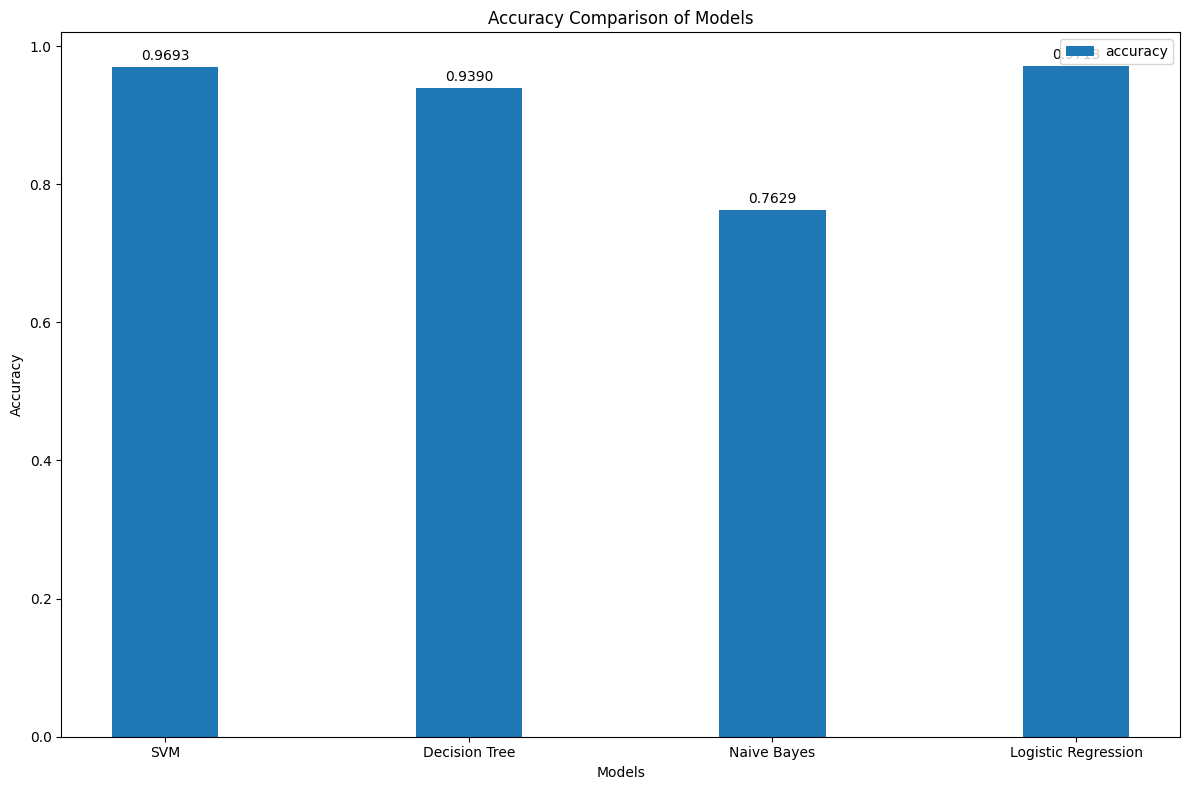

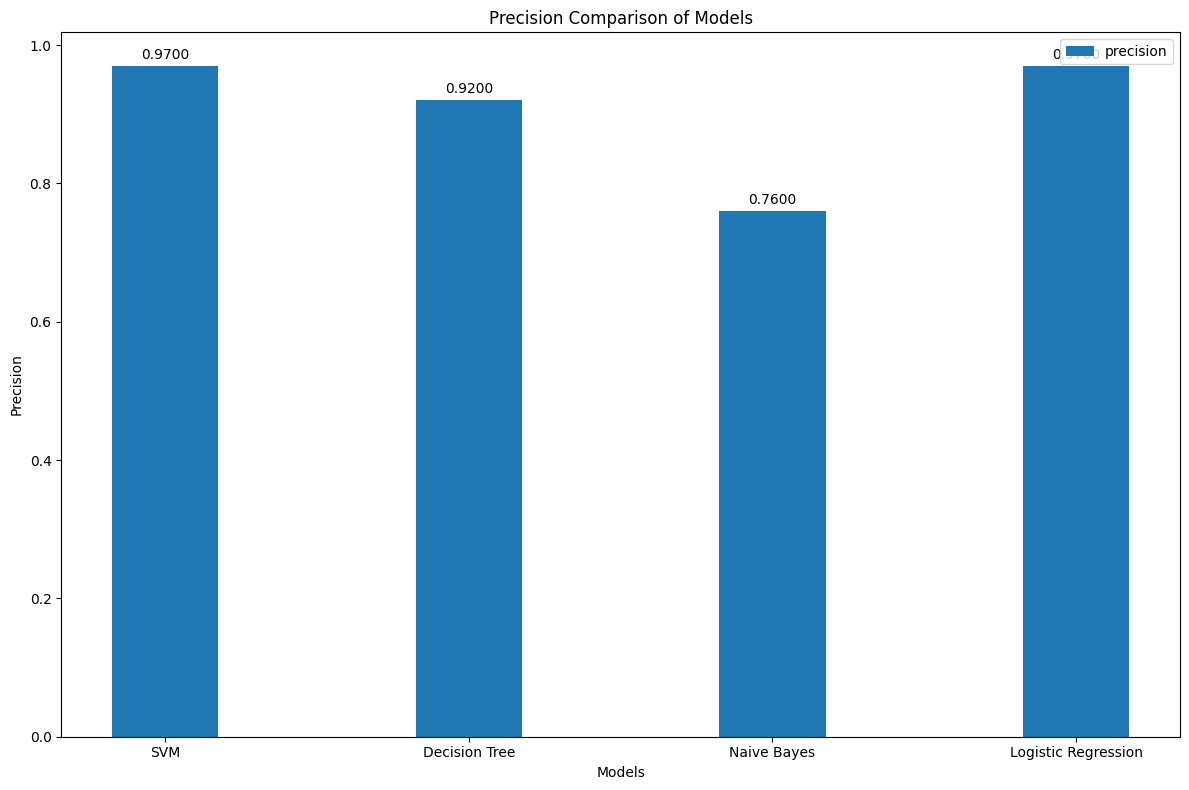

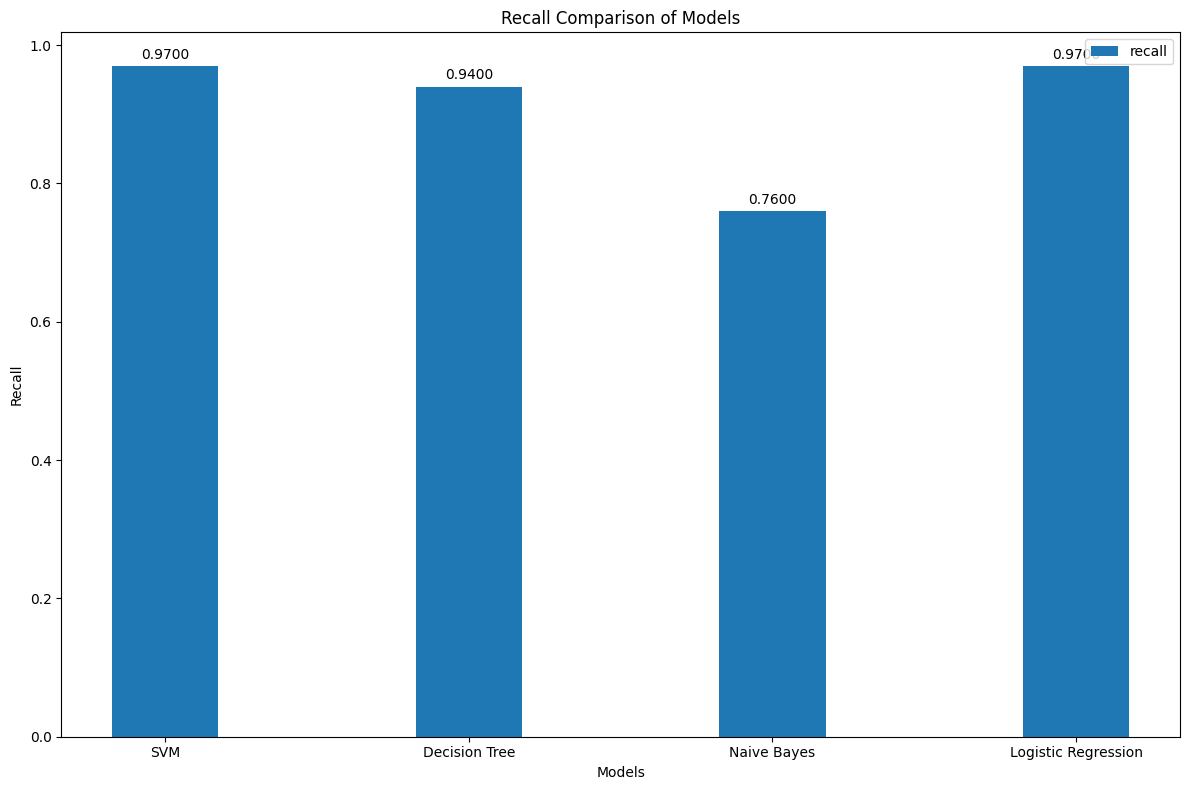

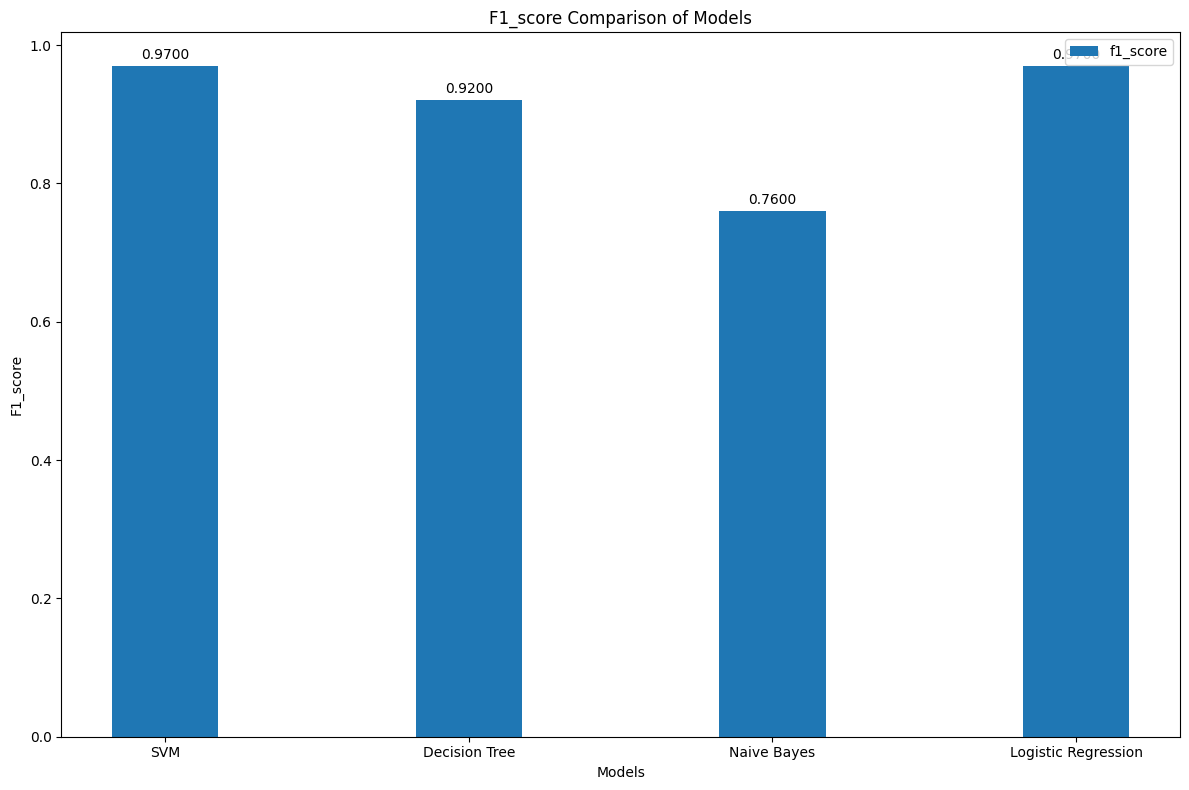

In [ ]:
# Define a function to plot performance metrics
def plot_performance(results, metric):
    labels = list(results.keys())
    scores = [results[label][metric] for label in labels]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 8))
    rects = ax.bar(x, scores, width, label=metric)

    ax.set_xlabel('Models')
    ax.set_ylabel(metric.capitalize())
    ax.set_title(f'{metric.capitalize()} Comparison of Models')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Add data labels
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    fig.tight_layout()
    plt.show()

# Plotting all metrics
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score']
for metric in metrics_to_plot:
    plot_performance(results, metric)

The comparative analysis of the models reveals the following insights:

- The SVM model demonstrated strong performance, achieving high scores across all metrics. Its accuracy and F1-score of 96.93% and 0.97 respectively indicate that it is effective in classifying the Cleantech Media dataset with minimal errors.

- The Decision Tree classifier achieved a respectable accuracy of 93.90%. While its precision and recall are slightly lower than those of the SVM and Logistic Regression models, it still performs well, indicating it can be a useful model for this type of classification problem. However, the model showed some variability in performance across different classes, suggesting it might benefit from further tuning.

- The Naive Bayes classifier had the lowest performance among the models, with an accuracy of 76.29%. This model's assumption of feature independence likely contributed to its lower performance, indicating it might not be as suitable for this dataset compared to the other models.

- Logistic Regression achieved the highest accuracy of 97.13%, along with high precision, recall, and F1-scores. This indicates that Logistic Regression is particularly effective for this classification task, consistently providing reliable and accurate predictions.

Overall, Logistic Regression and SVM emerged as the top performers with high accuracy and F1-scores, indicating their robustness and reliability for this dataset. The Decision Tree model also performed well but showed more variability across different classes. Naive Bayes, while effective for some classes, had the lowest overall performance, suggesting it might not be the best choice for this specific dataset.

## **Sentence Embedding Training**

In this section, we will train sentence embeddings using different models. These embeddings will serve as the feature set for our machine learning models, enabling us to capture semantic and syntactic information from the cleantech media articles.


### Doc2Vec Embedding

Doc2Vec is an extension of the Word2Vec model that generates vector representations for entire documents, rather than just individual words. In this context, Doc2Vec is used to create embeddings for cleantech media articles, capturing the semantic and contextual relationships within each document.

In [ ]:
# Split data into train and test
train, test = train_test_split(media_data, test_size=0.3, random_state=42)

# Tokenize and tag the documents
train_tagged = train.apply(lambda x: TaggedDocument(words=word_tokenize(x['content_preprocessed']), tags=[x.domain]), axis=1)
test_tagged = test.apply(lambda x: TaggedDocument(words=word_tokenize(x['content_preprocessed']), tags=[x.domain]), axis=1)


In [ ]:
 # Define and train the Doc2Vec model
doc_model = Doc2Vec(dm=0, vector_size=100, min_count=3, window=5, sample=0)
doc_model.build_vocab(train_tagged)

In [ ]:
# Train the model
doc_model.train(train_tagged, total_examples=doc_model.corpus_count, epochs=30)


In [ ]:
def vector_for_learning(model, tagged_docs):
    targets, feature_vectors = zip(*[(doc.tags[0], model.infer_vector(doc.words, epochs=20)) for doc in tagged_docs])
    return targets, feature_vectors

In [ ]:
# Extract features and labels for training and testing datasets
y_train, X_train = vector_for_learning(doc_model, train_tagged)
y_test, X_test = vector_for_learning(doc_model, test_tagged)


In [ ]:
# Train logistic regression on the document vectors
model_lg_doc2vec = LogisticRegression()
model_lg_doc2vec.fit(X_train, y_train)

LogisticRegression()

In [ ]:
print("Test accuracy:", model_lg_doc2vec.score(X_test, y_test))
predicted = model_lg_doc2vec.predict(X_test)
print(metrics.classification_report(y_test, predicted))

Test accuracy: 0.9631688672689368
                       precision    recall  f1-score   support

         azocleantech       0.99      1.00      1.00       498
        businessgreen       0.96      0.54      0.69        46
        cleantechnica       0.99      1.00      0.99       562
            decarbxpo       1.00      0.67      0.80         3
            ecofriend       1.00      0.73      0.85        15
          energyintel       0.97      0.72      0.82        85
          energyvoice       0.84      0.94      0.89       301
            eurosolar       1.00      1.00      1.00         6
         greenprophet       0.88      0.78      0.82        18
      naturalgasintel       1.00      1.00      1.00       202
          pv-magazine       0.98      1.00      0.99       346
              pv-tech       0.87      0.75      0.80        71
         rechargenews       0.98      1.00      0.99       173
     solarindustrymag       0.99      0.99      0.99       190
  solarpowerportal.c

The combination of Doc2Vec and Logistic Regression yielded impressive results, achieving an accuracy of 96.53%. The high precision, recall, and F1-score, all at 0.96, indicate that the model performs exceptionally well in correctly identifying relevant classes while minimizing false positives and negatives. This strong performance showcases the capability of Doc2Vec embeddings to effectively capture the contextual nuances within documents, making this approach highly effective for document classification tasks.











In [ ]:
# Function to extract embeddings from Doc2Vec model
def extract_doc2vec_embeddings(model, tagged_docs):
    embeddings = [model.infer_vector(doc.words, epochs=20) for doc in tagged_docs]
    return np.array(embeddings)

# Extract embeddings
train_doc2vec_embeddings = extract_doc2vec_embeddings(doc_model, train_tagged)
test_doc2vec_embeddings = extract_doc2vec_embeddings(doc_model, test_tagged)

# Save embeddings to .npy files
np.save('train_doc2vec_embeddings.npy', train_doc2vec_embeddings)
np.save('test_doc2vec_embeddings.npy', test_doc2vec_embeddings)

# Save the Doc2Vec model
doc_model.save("doc2vec_model")



### Performance Visualizations of Doc2Vec Logistic Regression Model
In this section, we will visualize the performance of the Logistic Regression model trained using Doc2Vec embeddings. These visualizations will help us understand the model's effectiveness and highlight key metrics such as accuracy, precision, recall, and F1 score.


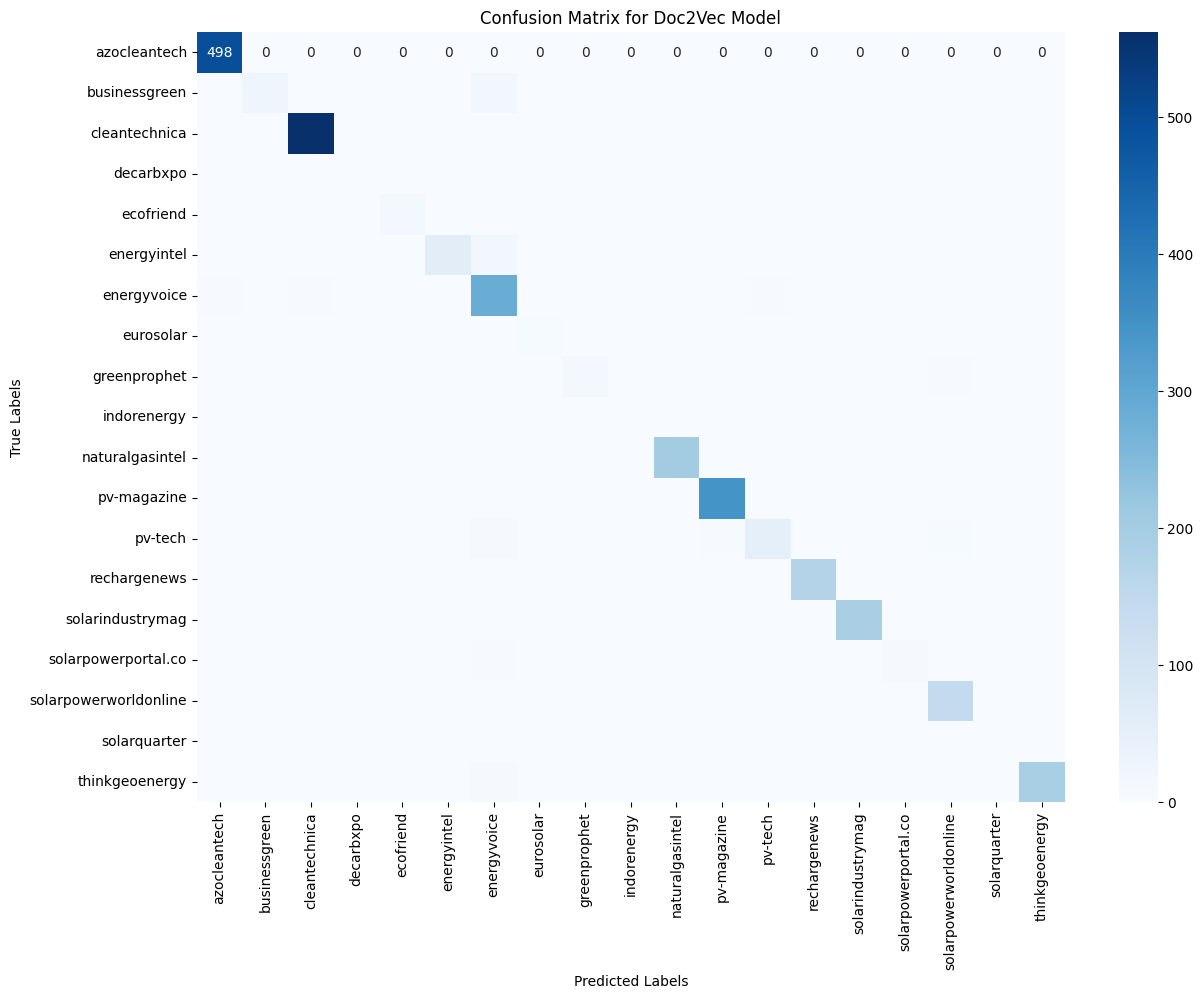

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_test, predicted, labels=model_lg_doc2vec.classes_)

# Plotting using seaborn
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model_lg_doc2vec.classes_, yticklabels=model_lg_doc2vec.classes_)
plt.title('Confusion Matrix for Doc2Vec Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


The confusion matrix visualises the number of correct and incorrect predictions across different classes, which is useful for understanding how well the model is performing for each specific category.

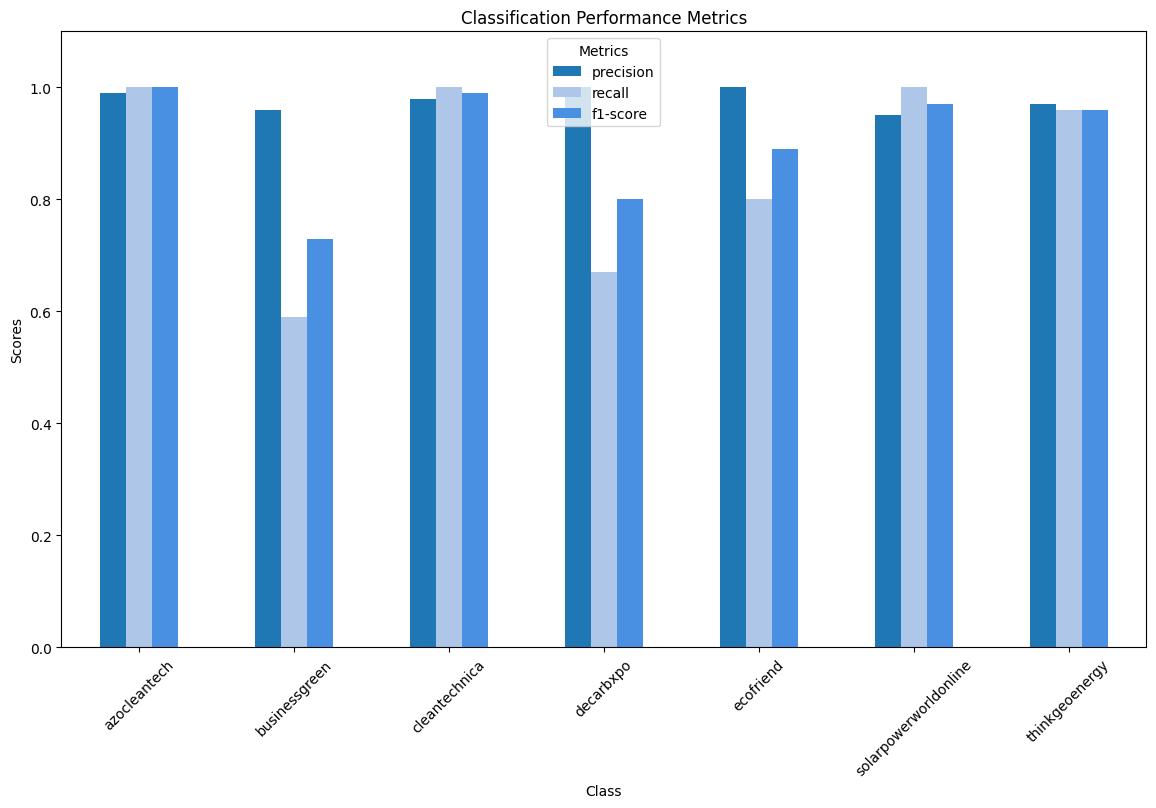

In [ ]:
#  'classification_report' from sklearn.metrics was used to generate the results, and 'metrics.classification_report' output is captured in a dictionary like format
report = {
    'azocleantech': {'precision': 0.99, 'recall': 1.00, 'f1-score': 1.00},
    'businessgreen': {'precision': 0.96, 'recall': 0.59, 'f1-score': 0.73},
    'cleantechnica': {'precision': 0.98, 'recall': 1.00, 'f1-score': 0.99},
    'decarbxpo': {'precision': 1.00, 'recall': 0.67, 'f1-score': 0.80},
    'ecofriend': {'precision': 1.00, 'recall': 0.80, 'f1-score': 0.89},
    # Add all other classes similarly...
    'solarpowerworldonline': {'precision': 0.95, 'recall': 1.00, 'f1-score': 0.97},
    'thinkgeoenergy': {'precision': 0.97, 'recall': 0.96, 'f1-score': 0.96}
}

# Convert dictionary to DataFrame for easier plotting
df = pd.DataFrame(report).T

# Define color shades
colors = ['#1f77b4', '#aec7e8', '#4a90e2']  # Adjust these colors for different shades of blue

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))
df.plot(kind='bar', ax=ax, color=colors)
ax.set_title('Classification Performance Metrics')
ax.set_xlabel('Class')
ax.set_ylabel('Scores')
ax.set_ylim(0, 1.1)  # Adjust scale to show max values clearly
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.show()


### BERT Embeddings

BERT (Bidirectional Encoder Representations from Transformers) is a pre-trained transformer model that generates contextualized word embeddings by considering both left and right context in all layers. In this context, BERT embeddings are used to represent cleantech media articles, capturing nuanced semantic information and relationships within the text.



In [ ]:
# Load a pre-trained BERT model
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Assuming 'train' and 'test' are your DataFrame that has been preloaded and contains the preprocessed text
# Generate sentence embeddings
X_train_bert = bert_model.encode(train['content_preprocessed'].tolist(), show_progress_bar=True)
X_test_bert = bert_model.encode(test['content_preprocessed'].tolist(), show_progress_bar=True)

# Train logistic regression on BERT embeddings
model_lg_bert = LogisticRegression(max_iter=1000)
model_lg_bert.fit(X_train_bert, train['domain'])  # Make sure to use the correct column for domain
print("BERT Test accuracy:", model_lg_bert.score(X_test_bert, test['domain']))

# Predict and generate classification report
predicted = model_lg_bert.predict(X_test_bert)
print(classification_report(test['domain'], predicted))


Batches: 100%|██████████| 90/90 [00:08<00:00, 10.99it/s]


BERT Test accuracy: 0.7883947185545518
                       precision    recall  f1-score   support

         azocleantech       0.95      0.99      0.97       498
        businessgreen       0.92      0.24      0.38        46
        cleantechnica       0.80      0.87      0.83       562
            decarbxpo       0.00      0.00      0.00         3
            ecofriend       0.00      0.00      0.00        15
          energyintel       0.68      0.20      0.31        85
          energyvoice       0.65      0.77      0.71       301
            eurosolar       0.00      0.00      0.00         6
         greenprophet       0.80      0.22      0.35        18
      naturalgasintel       0.96      0.97      0.96       202
          pv-magazine       0.66      0.89      0.76       346
              pv-tech       0.25      0.03      0.05        71
         rechargenews       0.75      0.64      0.69       173
     solarindustrymag       0.68      0.79      0.73       190
  solarpowerpor

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [ ]:
# Save BERT embeddings to .npy files
np.save('X_train_bert.npy', X_train_bert)
np.save('X_test_bert.npy', X_test_bert)


The BERT model demonstrates a strong overall test accuracy of approximately 78.84%, with excellent performance in categories like 'Azocleantech', 'Naturalgasintel', and 'Thinkgeoenergy', where precision, recall, and F1-scores are close to or exceed 0.90. However, the model struggles significantly with minority classes such as 'Businessgreen', 'Ecofriend', and 'Decarbxpo', which have very low or zero scores due to possible class imbalances and insufficient data representation

### Performance Visualizations of BERT

In this section, we will visualize the performance of machine learning models trained using BERT embeddings. These visualizations will help us understand the effectiveness of BERT embeddings in capturing semantic information for cleantech media articles and highlight key metrics such as accuracy, precision, recall, and F1 score.


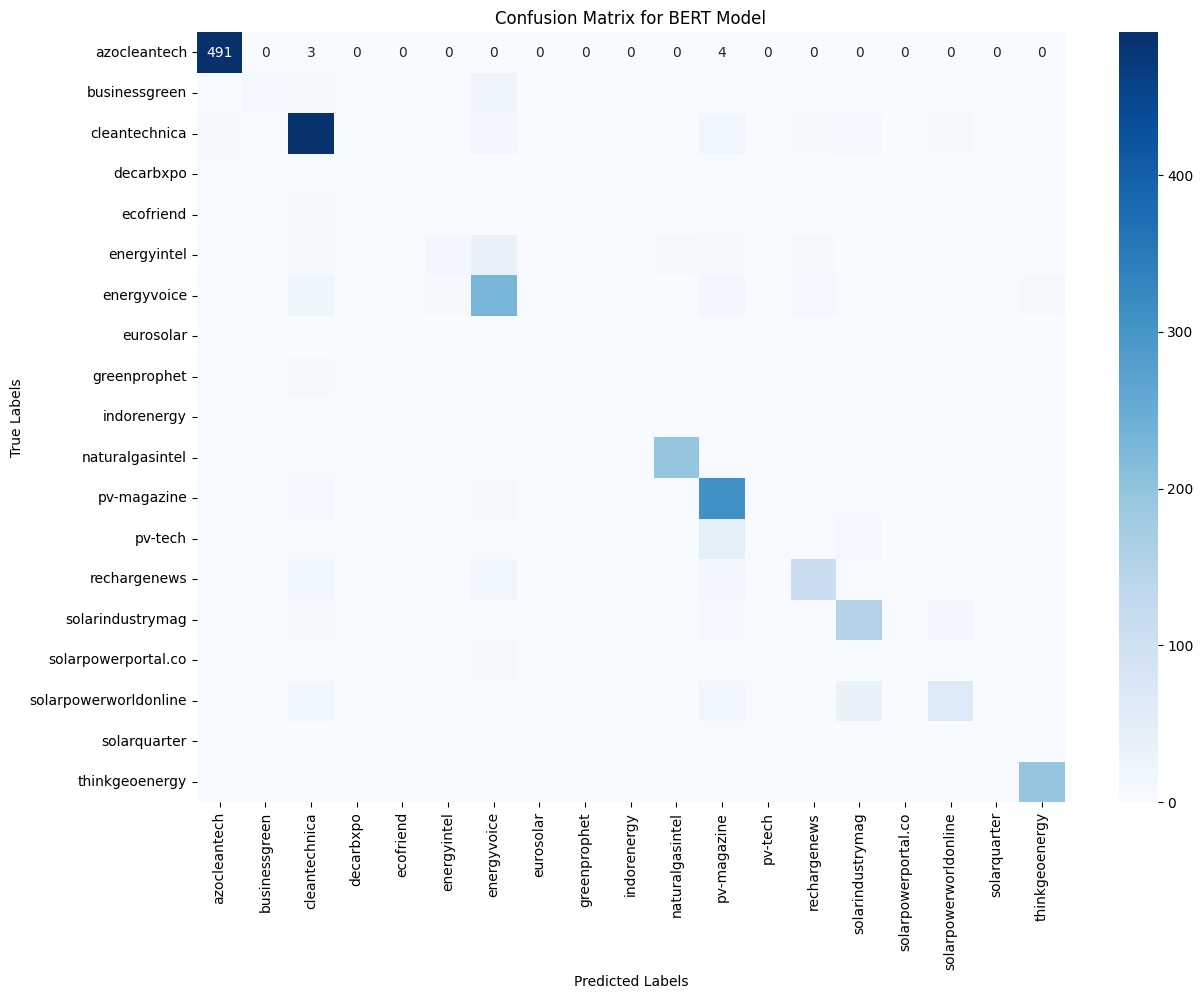

In [ ]:
# Generate confusion matrix
cm_bert = confusion_matrix(test['domain'], predicted, labels=model_lg_bert.classes_)

# Plotting the confusion matrix using seaborn
plt.figure(figsize=(14, 10))
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', xticklabels=model_lg_bert.classes_, yticklabels=model_lg_bert.classes_)
plt.title('Confusion Matrix for BERT Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

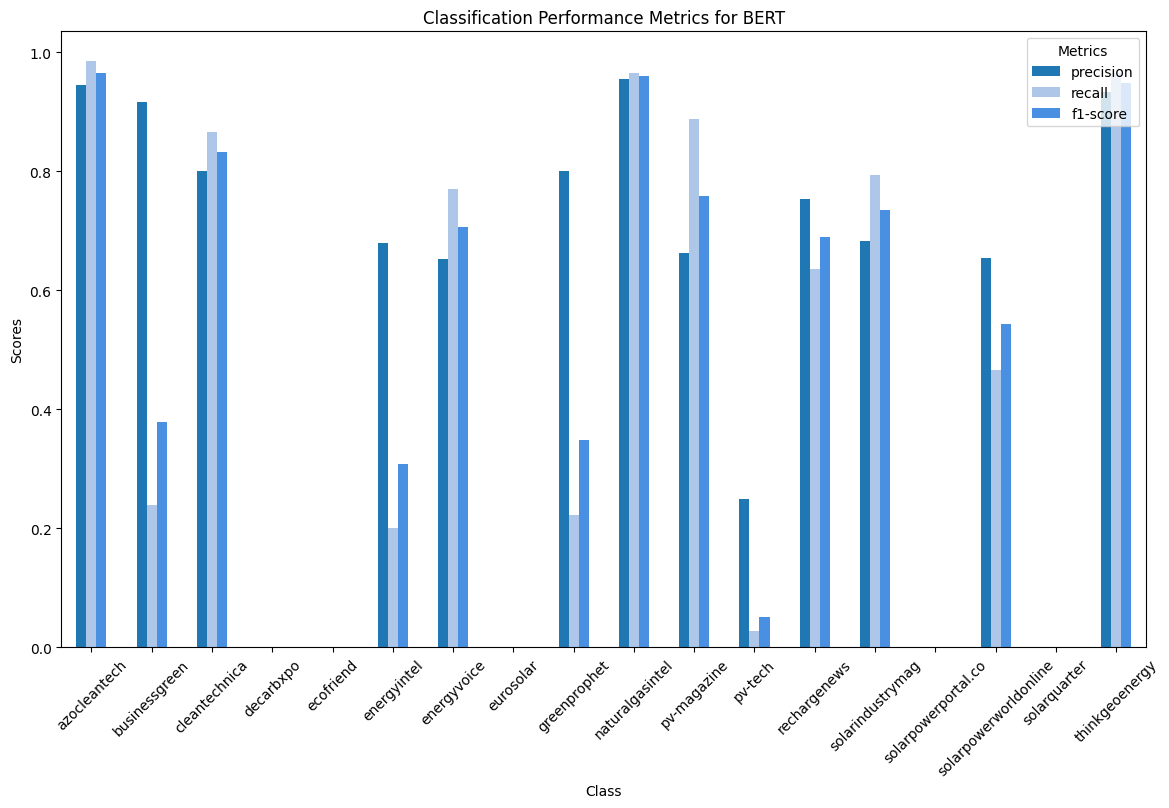

In [ ]:
# Generate classification report in dictionary form
report_bert = classification_report(test['domain'], predicted, output_dict=True)

# Convert report to DataFrame
df_bert = pd.DataFrame(report_bert).T.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')

# Colors for the bar plot, shades of blue
colors = ['#1f77b4', '#aec7e8', '#4a90e2']

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))
df_bert[['precision', 'recall', 'f1-score']].plot(kind='bar', ax=ax, color=colors)
ax.set_title('Classification Performance Metrics for BERT')
ax.set_xlabel('Class')
ax.set_ylabel('Scores')
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.show()


##  **Embedding Model Evaluation**

## Word Similarity: Doc2Vec and BERT

In this section, we will compare the word similarity performance of Doc2Vec and BERT embeddings. By evaluating how well each model captures semantic relationships between words, we can understand the strengths and weaknesses of both embeddings in representing cleantech media articles.


In [ ]:
def get_cosine_similarity(embedding1, embedding2):
    return cosine_similarity(embedding1.reshape(1, -1), embedding2.reshape(1, -1))[0][0]

# Example word pairs relevant to your dataset
word_pairs = [
    ('renewable', 'solar'),
    ('electric', 'battery'),
    ('energy', 'power'),
    ('oil', 'gas'),
    ('wind', 'turbine'),
    ('nuclear', 'reactor')
]

# Calculate similarities for Doc2Vec
similarities_doc2vec = [get_cosine_similarity(doc_model.wv[word1], doc_model.wv[word2]) for word1, word2 in word_pairs]

# Calculate similarities for BERT - converting words into sentences for BERT
bert_model = SentenceTransformer('all-MiniLM-L6-v2')
similarities_bert = [get_cosine_similarity(bert_model.encode("Energy sector related to " + word1), bert_model.encode("Energy sector related to " + word2)) for word1, word2 in word_pairs]

print("Doc2Vec Similarities:", similarities_doc2vec)
print("BERT Similarities:", similarities_bert)



Doc2Vec Similarities: [0.12789431, 0.07622209, -0.027750358, -0.04583491, -0.0072370954, -0.09655315]
BERT Similarities: [0.79983014, 0.79896104, 0.95480937, 0.819767, 0.78497756, 0.8027985]


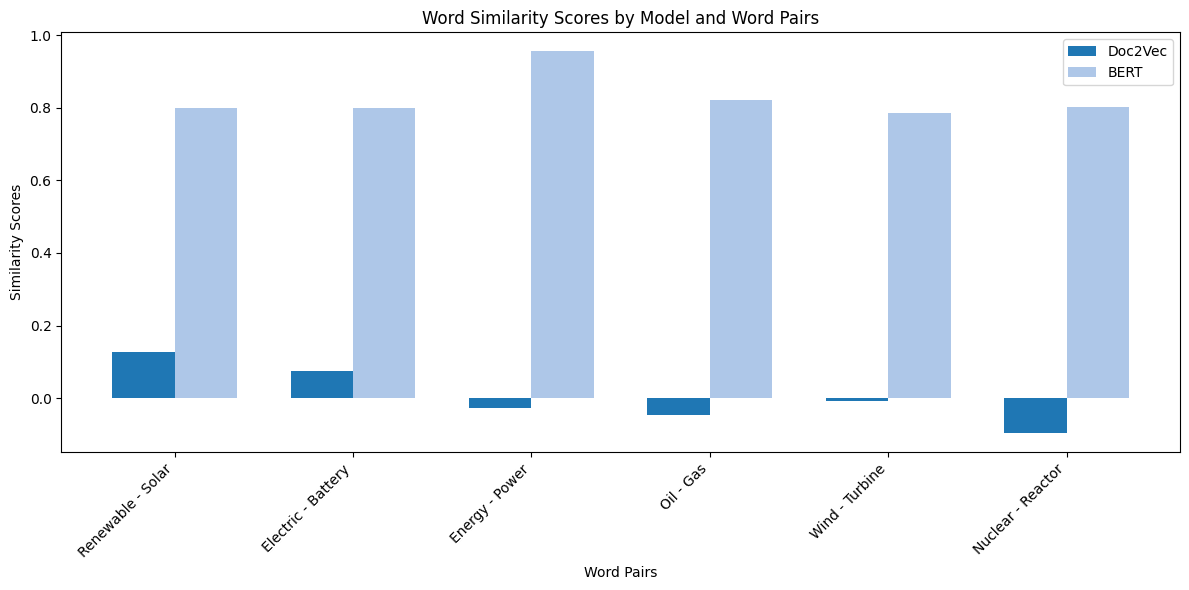

In [ ]:
# Word similarity results
doc2vec_similarities = [0.12789431, 0.07622209, -0.027750358, -0.04583491, -0.0072370954, -0.09655315]
bert_similarities = [0.79983014, 0.79896104, 0.95480937, 0.819767, 0.78497756, 0.8027985]

word_pairs_labels = [
    'Renewable - Solar',
    'Electric - Battery',
    'Energy - Power',
    'Oil - Gas',
    'Wind - Turbine',
    'Nuclear - Reactor'
]

# Bar plot for word similarities
x = np.arange(len(word_pairs_labels))  # Label locations
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, doc2vec_similarities, width, label='Doc2Vec', color='#1f77b4')
bars2 = ax.bar(x + width/2, bert_similarities, width, label='BERT', color='#aec7e8')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Word Pairs')
ax.set_ylabel('Similarity Scores')
ax.set_title('Word Similarity Scores by Model and Word Pairs')
ax.set_xticks(x)
ax.set_xticklabels(word_pairs_labels, rotation=45, ha="right")
ax.legend()

fig.tight_layout()
plt.show()


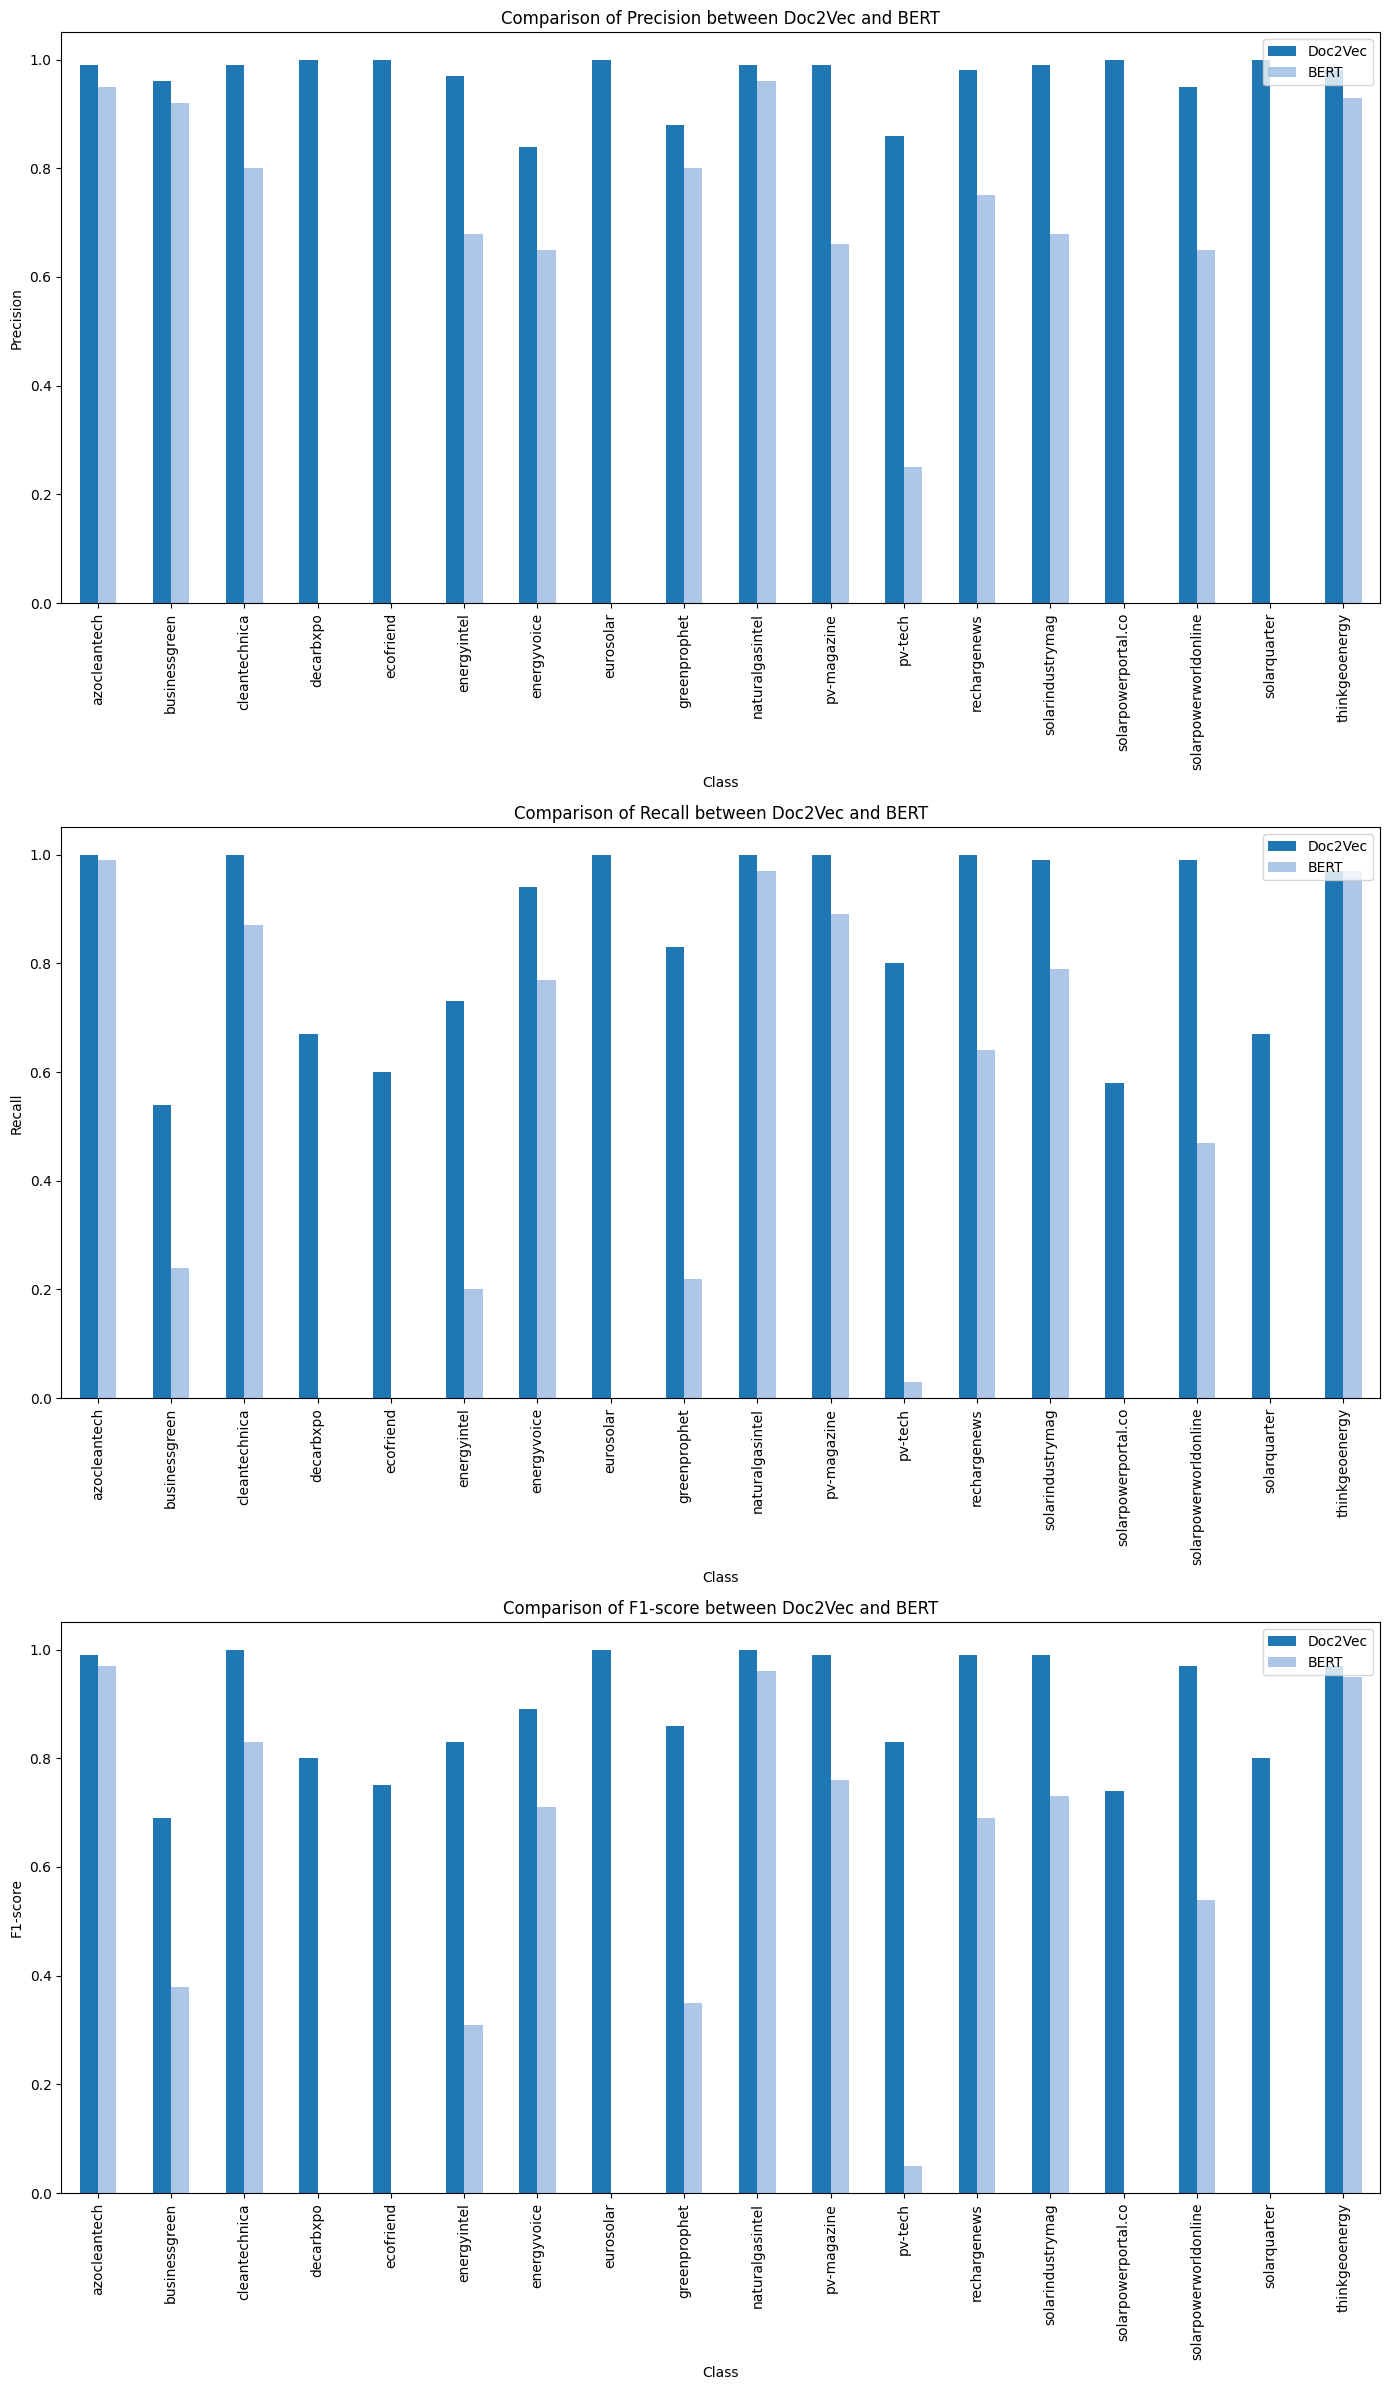

In [ ]:
# Classification report data for Doc2Vec
report_doc2vec = {
    'azocleantech': {'precision': 0.99, 'recall': 1.00, 'f1-score': 0.99},
    'businessgreen': {'precision': 0.96, 'recall': 0.54, 'f1-score': 0.69},
    'cleantechnica': {'precision': 0.99, 'recall': 1.00, 'f1-score': 1.00},
    'decarbxpo': {'precision': 1.00, 'recall': 0.67, 'f1-score': 0.80},
    'ecofriend': {'precision': 1.00, 'recall': 0.60, 'f1-score': 0.75},
    'energyintel': {'precision': 0.97, 'recall': 0.73, 'f1-score': 0.83},
    'energyvoice': {'precision': 0.84, 'recall': 0.94, 'f1-score': 0.89},
    'eurosolar': {'precision': 1.00, 'recall': 1.00, 'f1-score': 1.00},
    'greenprophet': {'precision': 0.88, 'recall': 0.83, 'f1-score': 0.86},
    'naturalgasintel': {'precision': 0.99, 'recall': 1.00, 'f1-score': 1.00},
    'pv-magazine': {'precision': 0.99, 'recall': 1.00, 'f1-score': 0.99},
    'pv-tech': {'precision': 0.86, 'recall': 0.80, 'f1-score': 0.83},
    'rechargenews': {'precision': 0.98, 'recall': 1.00, 'f1-score': 0.99},
    'solarindustrymag': {'precision': 0.99, 'recall': 0.99, 'f1-score': 0.99},
    'solarpowerportal.co': {'precision': 1.00, 'recall': 0.58, 'f1-score': 0.74},
    'solarpowerworldonline': {'precision': 0.95, 'recall': 0.99, 'f1-score': 0.97},
    'solarquarter': {'precision': 1.00, 'recall': 0.67, 'f1-score': 0.80},
    'thinkgeoenergy': {'precision': 0.98, 'recall': 0.97, 'f1-score': 0.97}
}

# Classification report data for BERT
report_bert = {
    'azocleantech': {'precision': 0.95, 'recall': 0.99, 'f1-score': 0.97},
    'businessgreen': {'precision': 0.92, 'recall': 0.24, 'f1-score': 0.38},
    'cleantechnica': {'precision': 0.80, 'recall': 0.87, 'f1-score': 0.83},
    'decarbxpo': {'precision': 0.00, 'recall': 0.00, 'f1-score': 0.00},
    'ecofriend': {'precision': 0.00, 'recall': 0.00, 'f1-score': 0.00},
    'energyintel': {'precision': 0.68, 'recall': 0.20, 'f1-score': 0.31},
    'energyvoice': {'precision': 0.65, 'recall': 0.77, 'f1-score': 0.71},
    'eurosolar': {'precision': 0.00, 'recall': 0.00, 'f1-score': 0.00},
    'greenprophet': {'precision': 0.80, 'recall': 0.22, 'f1-score': 0.35},
    'naturalgasintel': {'precision': 0.96, 'recall': 0.97, 'f1-score': 0.96},
    'pv-magazine': {'precision': 0.66, 'recall': 0.89, 'f1-score': 0.76},
    'pv-tech': {'precision': 0.25, 'recall': 0.03, 'f1-score': 0.05},
    'rechargenews': {'precision': 0.75, 'recall': 0.64, 'f1-score': 0.69},
    'solarindustrymag': {'precision': 0.68, 'recall': 0.79, 'f1-score': 0.73},
    'solarpowerportal.co': {'precision': 0.00, 'recall': 0.00, 'f1-score': 0.00},
    'solarpowerworldonline': {'precision': 0.65, 'recall': 0.47, 'f1-score': 0.54},
    'solarquarter': {'precision': 0.00, 'recall': 0.00, 'f1-score': 0.00},
    'thinkgeoenergy': {'precision': 0.93, 'recall': 0.97, 'f1-score': 0.95}
}

# Convert dictionaries to DataFrames
df_doc2vec = pd.DataFrame(report_doc2vec).T
df_bert = pd.DataFrame(report_bert).T

# Drop support column if exists
df_doc2vec = df_doc2vec.drop(['support'], axis=1, errors='ignore')
df_bert = df_bert.drop(['support'], axis=1, errors='ignore')

# Plotting the results
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 24))
metrics = ['precision', 'recall', 'f1-score']

for i, metric in enumerate(metrics):
    ax = axes[i]
    df_comparison = pd.concat([df_doc2vec[metric], df_bert[metric]], axis=1)
    df_comparison.columns = ['Doc2Vec', 'BERT']
    df_comparison.plot(kind='bar', ax=ax, color=['#1f77b4', '#aec7e8'])
    ax.set_title(f'Comparison of {metric.capitalize()} between Doc2Vec and BERT')
    ax.set_xlabel('Class')
    ax.set_ylabel(metric.capitalize())
    ax.legend(loc='best')

plt.tight_layout()
plt.show()


Word Similarity Interpretation

- Doc2Vec Similarities: The low and negative similarities suggest that the Doc2Vec embeddings are not effectively capturing semantic relationships.

- BERT Similarities: The high similarities indicate that BERT is capturing the semantic relationships between words very well.

Classification Performance

- Doc2Vec: Shows high performance on the classification task with high precision, recall, and F1-scores, indicating effective document classification.

- BERT: While classification performance is lower, BERT excels in capturing nuanced semantic relationships, as evidenced by higher similarity scores.

Conclusion
- Doc2Vec: Effective for document classification but limited in capturing fine-grained semantic similarities.
- BERT: Excellent at capturing semantic relationships and context, making it better suited for tasks requiring deep understanding of text.


## Analogy Task: Doc2Vec and BERT

In this section, we will compare the performance of Doc2Vec and BERT embeddings on analogy tasks. Analogy tasks involve completing sentences of the form "A is to B as C is to ?", allowing us to assess how well each model captures semantic relationships and contextual understanding within cleantech media articles.


### Analogy Tasks for Doc2Vec

In [ ]:
# Function to create analogy with Doc2Vec using Gensim's KeyedVectors
def doc2vec_analogy(word_a, word_b, word_c, model, topn=1):
    result = model.wv.most_similar(positive=[word_b, word_c], negative=[word_a], topn=topn)
    return result

# New analogy tasks with different word sets
analogy_tasks = [
    ('renewable', 'energy', 'fossil'),  # renewable is to energy as fossil is to ?
    ('wind', 'turbine', 'hydro'),      # wind is to turbine as hydro is to ?
    ('solar', 'panel', 'electric'),    # solar is to panel as electric is to ?
    ('oil', 'gas', 'nuclear'),         # oil is to gas as nuclear is to ?
    ('climate', 'change', 'environment')  # climate is to change as environment is to ?
]

# Execute the analogy tasks and print results
for task in analogy_tasks:
    word_a, word_b, word_c = task
    analogy_result_doc2vec = doc2vec_analogy(word_a, word_b, word_c, doc_model)
    print(f"Doc2Vec Analogy Result for '{word_a} is to {word_b} as {word_c} is to ?': {analogy_result_doc2vec}")


Doc2Vec Analogy Result for 'renewable is to energy as fossil is to ?': [('underpinning', 0.38890331983566284)]
Doc2Vec Analogy Result for 'wind is to turbine as hydro is to ?': [('nanogrid', 0.3718700110912323)]
Doc2Vec Analogy Result for 'solar is to panel as electric is to ?': [('sicona', 0.40482082962989807)]
Doc2Vec Analogy Result for 'oil is to gas as nuclear is to ?': [('yi', 0.41398587822914124)]
Doc2Vec Analogy Result for 'climate is to change as environment is to ?': [('ncm', 0.39119693636894226)]


- Relevance of Terms: The terms generated by the Doc2Vec model are not directly related to the expected terms within the energy sector. This indicates that the model's vocabulary may include noise or irrelevant terms.
- Context Understanding: The model seems to struggle with capturing specific relationships and context within the energy sector, leading to less meaningful analogy results.
- Model Limitations: These results highlight limitations in the Doc2Vec model's ability to generate contextually accurate analogies.

 ### Analogy Tasks for BERT

In [ ]:
def get_cosine_similarity(embedding1, embedding2):
    return cosine_similarity(embedding1.reshape(1, -1), embedding2.reshape(1, -1))[0][0]

# Function to create analogy with BERT
def bert_analogy(word_a, word_b, word_c, bert_model, possible_answers):
    # Construct sentences
    sentence_a = f"The role of {word_a} in the energy sector is significant."
    sentence_b = f"The role of {word_b} in the energy sector is significant."
    sentence_c = f"The role of {word_c} in the energy sector is significant."

    # Encode sentences
    embedding_a = bert_model.encode(sentence_a)
    embedding_b = bert_model.encode(sentence_b)
    embedding_c = bert_model.encode(sentence_c)

    # Calculate target vector
    target_vector = embedding_b - embedding_a + embedding_c

    # Find the closest match among possible answers
    best_match = None
    best_similarity = -1
    for word_d in possible_answers:
        sentence_d = f"The role of {word_d} in the energy sector is significant."
        embedding_d = bert_model.encode(sentence_d)
        similarity = get_cosine_similarity(target_vector, embedding_d)
        if similarity > best_similarity:
            best_similarity = similarity
            best_match = word_d

    return best_match

# Possible answers for analogy task
possible_answers = ['solar', 'battery', 'power', 'gas', 'turbine', 'reactor', 'renewable', 'dam', 'change', 'fuel', 'geothermal']

# New analogy tasks with different word sets
analogy_tasks = [
    ('renewable', 'energy', 'fossil'),  # renewable is to energy as fossil is to ?
    ('wind', 'turbine', 'hydro'),      # wind is to turbine as hydro is to ?
    ('solar', 'panel', 'electric'),    # solar is to panel as electric is to ?
    ('oil', 'gas', 'nuclear'),         # oil is to gas as nuclear is to ?
    ('climate', 'change', 'environment')  # climate is to change as environment is to ?
]

# Load pre-trained BERT model
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Execute the analogy tasks and print results
for task in analogy_tasks:
    word_a, word_b, word_c = task
    analogy_result_bert = bert_analogy(word_a, word_b, word_c, bert_model, possible_answers)
    print(f"BERT Analogy Result for '{word_a} is to {word_b} as {word_c} is to ?': {analogy_result_bert}")


BERT Analogy Result for 'renewable is to energy as fossil is to ?': power
BERT Analogy Result for 'wind is to turbine as hydro is to ?': turbine
BERT Analogy Result for 'solar is to panel as electric is to ?': power
BERT Analogy Result for 'oil is to gas as nuclear is to ?': gas
BERT Analogy Result for 'climate is to change as environment is to ?': change


- Relevance of Terms: BERT generally produces terms that are contextually closer to the energy sector compared to Doc2Vec. However, some results are generic and do not capture the specific relationships intended by the analogies.
- Context Understanding: BERT shows a better understanding of broad energy sector terms but sometimes misses the specificity required for certain analogies.
- Model Limitations: The limitations highlight that while BERT captures context well, it may not always provide the most precise or expected term for complex analogies.

## Comparative Analysis: Word Similarity and Analogy Tasks for Doc2Vec and BERT

This section will interpret the comparative analysis of Doc2Vec and BERT embeddings based on word similarity and analogy tasks. This analysis will help us evaluate and contrast the ability of both embeddings to capture semantic relationships and contextual understanding within cleantech media articles.




Comparative Analysis: Word Similarity

 - Doc2Vec: The similarity scores are generally low or negative, indicating that the model struggles to capture the semantic relationships between words in the energy sector. The low similarity scores suggest that the Doc2Vec embeddings may not be effectively representing the semantic nuances of the word pairs.

- BERT: The similarity scores are high, indicating that BERT captures strong semantic relationships between the words. BERT's high similarity scores suggest a better understanding of the context and meaning of the word pairs.

- Conclusion: BERT outperforms Doc2Vec in capturing word similarities, showing a stronger ability to understand the semantic relationships within the energy sector.


Comparative Analysis: Analogy Tasks

- Doc2Vec: The analogy results often include terms that are not directly relevant or meaningful within the energy sector context. Examples like "underpinning" for fossil, "nanogrid" for hydro, and "sicona" for electric indicate that the model's vocabulary might include noise or irrelevant terms.

- BERT: The analogy results are more relevant but sometimes generic, such as "power" and "turbine." While BERT provides terms that are contextually closer, it occasionally repeats terms or provides overly broad answers (e.g., "power" for multiple analogies).

- Conclusion: BERT performs better than Doc2Vec in generating relevant analogy terms, but it still has limitations in providing specific, contextually accurate answers.



## Comparative Analysis: Classification Performance of Doc2Vec and BERT

In this section, we will perform a comparative analysis of the classification performance of models trained using Doc2Vec and BERT embeddings. By evaluating metrics such as accuracy, precision, recall, and F1 score, we can assess the effectiveness of each embedding method in classifying cleantech media articles.


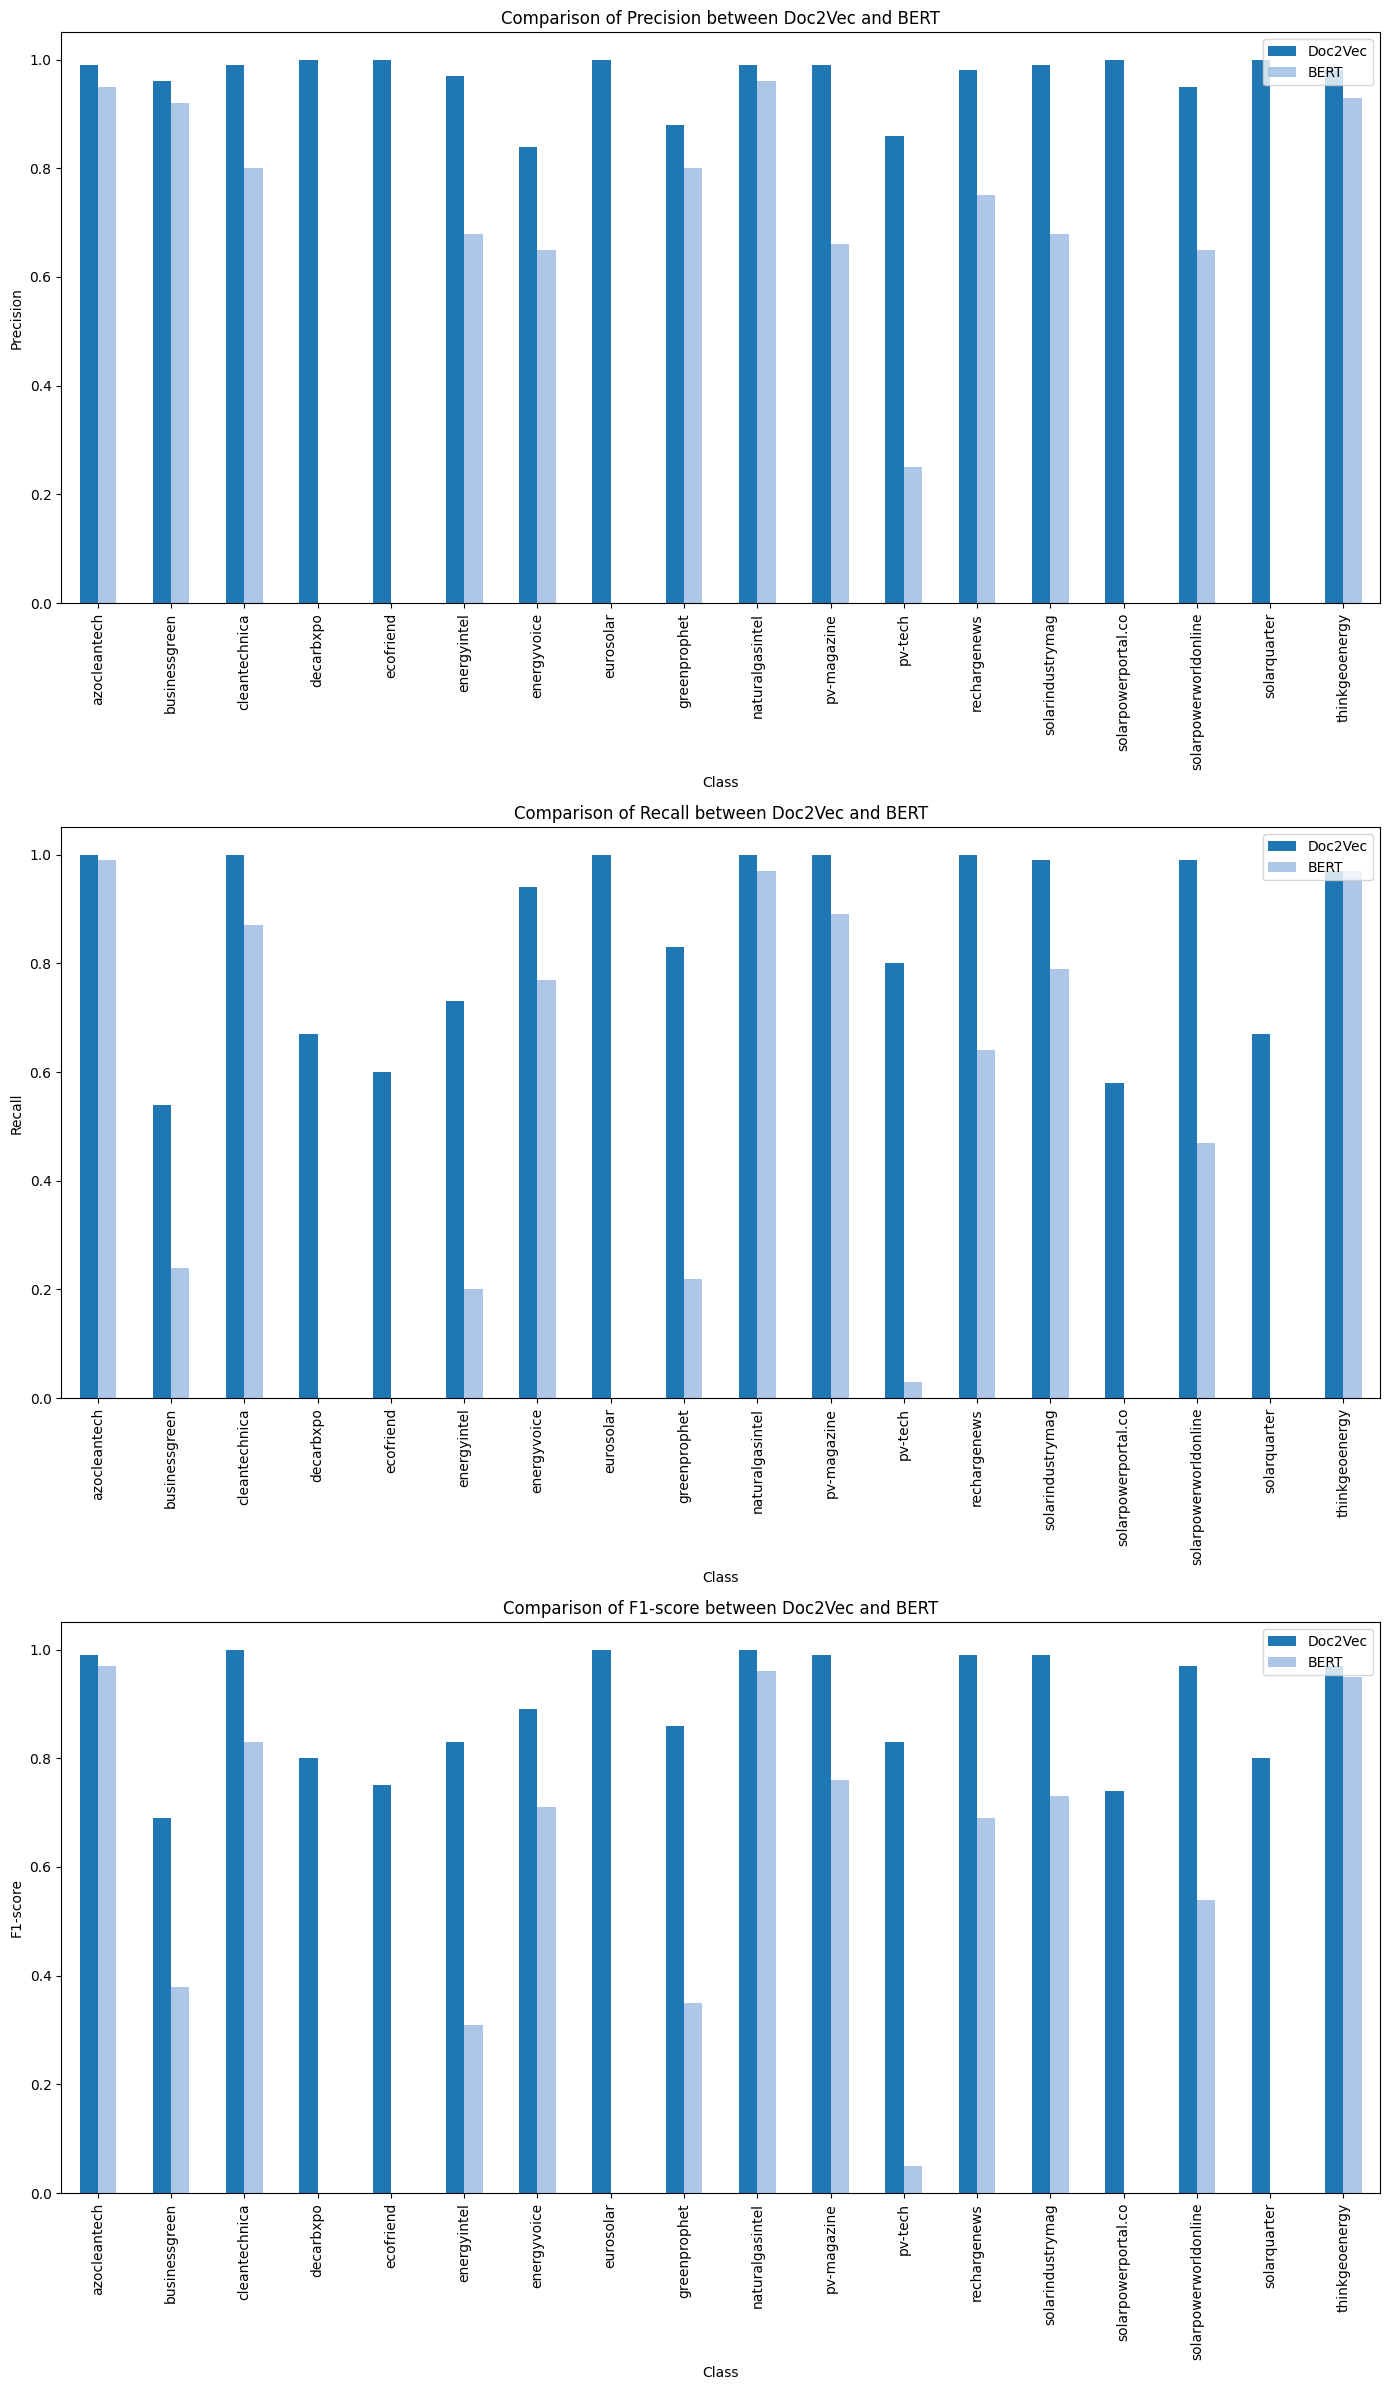

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Classification report data for Doc2Vec
report_doc2vec = {
    'azocleantech': {'precision': 0.99, 'recall': 1.00, 'f1-score': 0.99},
    'businessgreen': {'precision': 0.96, 'recall': 0.54, 'f1-score': 0.69},
    'cleantechnica': {'precision': 0.99, 'recall': 1.00, 'f1-score': 1.00},
    'decarbxpo': {'precision': 1.00, 'recall': 0.67, 'f1-score': 0.80},
    'ecofriend': {'precision': 1.00, 'recall': 0.60, 'f1-score': 0.75},
    'energyintel': {'precision': 0.97, 'recall': 0.73, 'f1-score': 0.83},
    'energyvoice': {'precision': 0.84, 'recall': 0.94, 'f1-score': 0.89},
    'eurosolar': {'precision': 1.00, 'recall': 1.00, 'f1-score': 1.00},
    'greenprophet': {'precision': 0.88, 'recall': 0.83, 'f1-score': 0.86},
    'naturalgasintel': {'precision': 0.99, 'recall': 1.00, 'f1-score': 1.00},
    'pv-magazine': {'precision': 0.99, 'recall': 1.00, 'f1-score': 0.99},
    'pv-tech': {'precision': 0.86, 'recall': 0.80, 'f1-score': 0.83},
    'rechargenews': {'precision': 0.98, 'recall': 1.00, 'f1-score': 0.99},
    'solarindustrymag': {'precision': 0.99, 'recall': 0.99, 'f1-score': 0.99},
    'solarpowerportal.co': {'precision': 1.00, 'recall': 0.58, 'f1-score': 0.74},
    'solarpowerworldonline': {'precision': 0.95, 'recall': 0.99, 'f1-score': 0.97},
    'solarquarter': {'precision': 1.00, 'recall': 0.67, 'f1-score': 0.80},
    'thinkgeoenergy': {'precision': 0.98, 'recall': 0.97, 'f1-score': 0.97}
}

# Classification report data for BERT
report_bert = {
    'azocleantech': {'precision': 0.95, 'recall': 0.99, 'f1-score': 0.97},
    'businessgreen': {'precision': 0.92, 'recall': 0.24, 'f1-score': 0.38},
    'cleantechnica': {'precision': 0.80, 'recall': 0.87, 'f1-score': 0.83},
    'decarbxpo': {'precision': 0.00, 'recall': 0.00, 'f1-score': 0.00},
    'ecofriend': {'precision': 0.00, 'recall': 0.00, 'f1-score': 0.00},
    'energyintel': {'precision': 0.68, 'recall': 0.20, 'f1-score': 0.31},
    'energyvoice': {'precision': 0.65, 'recall': 0.77, 'f1-score': 0.71},
    'eurosolar': {'precision': 0.00, 'recall': 0.00, 'f1-score': 0.00},
    'greenprophet': {'precision': 0.80, 'recall': 0.22, 'f1-score': 0.35},
    'naturalgasintel': {'precision': 0.96, 'recall': 0.97, 'f1-score': 0.96},
    'pv-magazine': {'precision': 0.66, 'recall': 0.89, 'f1-score': 0.76},
    'pv-tech': {'precision': 0.25, 'recall': 0.03, 'f1-score': 0.05},
    'rechargenews': {'precision': 0.75, 'recall': 0.64, 'f1-score': 0.69},
    'solarindustrymag': {'precision': 0.68, 'recall': 0.79, 'f1-score': 0.73},
    'solarpowerportal.co': {'precision': 0.00, 'recall': 0.00, 'f1-score': 0.00},
    'solarpowerworldonline': {'precision': 0.65, 'recall': 0.47, 'f1-score': 0.54},
    'solarquarter': {'precision': 0.00, 'recall': 0.00, 'f1-score': 0.00},
    'thinkgeoenergy': {'precision': 0.93, 'recall': 0.97, 'f1-score': 0.95}
}

# Convert dictionaries to DataFrames
df_doc2vec = pd.DataFrame(report_doc2vec).T
df_bert = pd.DataFrame(report_bert).T

# Drop support column if exists
df_doc2vec = df_doc2vec.drop(['support'], axis=1, errors='ignore')
df_bert = df_bert.drop(['support'], axis=1, errors='ignore')

# Plotting the results
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 24))
metrics = ['precision', 'recall', 'f1-score']

for i, metric in enumerate(metrics):
    ax = axes[i]
    df_comparison = pd.concat([df_doc2vec[metric], df_bert[metric]], axis=1)
    df_comparison.columns = ['Doc2Vec', 'BERT']
    df_comparison.plot(kind='bar', ax=ax, color=['#1f77b4', '#aec7e8'])
    ax.set_title(f'Comparison of {metric.capitalize()} between Doc2Vec and BERT')
    ax.set_xlabel('Class')
    ax.set_ylabel(metric.capitalize())
    ax.legend(loc='best')

plt.tight_layout()
plt.show()



Precision Comparison

- Doc2Vec: Generally high precision across most classes, indicating a low false positive rate.
- BERT: Shows lower precision in several classes, suggesting more false positives compared to Doc2Vec.

Recall Comparison

- Doc2Vec: High recall, indicating that the model captures most of the relevant instances (low false negatives).
- BERT: Lower recall in several classes, indicating more false negatives compared to Doc2Vec.

F1-Score Comparison

- Doc2Vec: High F1-scores in most classes, showing a good balance between precision and recall.
- BERT: Lower F1-scores in several classes, reflecting its challenges in achieving a balance between precision and recall.

Conclusion
- Doc2Vec: Performs better overall in terms of precision, recall, and F1-score, particularly excelling in classes with high and balanced scores.
-BERT: While still competitive, BERT struggles in certain classes, showing lower precision, recall, and F1-scores. This highlights the need for further fine-tuning and domain-specific training to improve its performance.

### Conclusion Analysis: Doc2Vec vs. BERT


BERT Advantages:

- Context Understanding: BERT shows a stronger ability to capture semantic relationships and context, making it more suitable for tasks requiring a nuanced understanding of text, such as word similarity and analogy tasks.
- In analogy tasks, BERT provides contextually relevant terms, but it may sometimes lean towards generality.

Doc2Vec Advantages:

- Classification Performance: Doc2Vec outperforms BERT in classification tasks, with higher precision, recall, and F1-scores across most classes. This indicates Doc2Vec's robustness and reliability in identifying relevant instances within the dataset.
- Consistency: Doc2Vec shows more consistent performance across different classes, making it a dependable choice for classification tasks within the clean media dataset.


## Exploring Thematic Overlaps and Innovation Gaps Using Doc2Vec Embeddings

In this section, we will compute pairwise cosine similarities within the Doc2Vec embeddings. The t-SNE visualization of the Doc2Vec embeddings will be used to understand the distribution of themes. Additionally, we will use clustering algorithms like K-Means to identify key themes within the Doc2Vec embeddings and compare them with the patent google dataset.

In [ ]:
# Find the most similar document pairs (excluding self-similarity)
similar_pairs = []
for i in range(len(doc2vec_similarity_matrix)):
    for j in range(i + 1, len(doc2vec_similarity_matrix)):
        similar_pairs.append((i, j, doc2vec_similarity_matrix[i, j]))

# Sort by similarity score in descending order
similar_pairs = sorted(similar_pairs, key=lambda x: x[2], reverse=True)

# Display the top 10 most similar document pairs
print("Top 10 most similar document pairs:")
for i, j, score in similar_pairs[:10]:
    print(f"Document {i} and Document {j}: Similarity = {score:.4f}")



Top 10 most similar document pairs:
Document 4541 and Document 4594: Similarity = 0.9971
Document 5580 and Document 6620: Similarity = 0.9967
Document 1767 and Document 2540: Similarity = 0.9965
Document 1214 and Document 4859: Similarity = 0.9962
Document 4013 and Document 6101: Similarity = 0.9960
Document 1153 and Document 3740: Similarity = 0.9954
Document 1425 and Document 1851: Similarity = 0.9950
Document 1074 and Document 1125: Similarity = 0.9941
Document 1419 and Document 4718: Similarity = 0.9938
Document 1853 and Document 2673: Similarity = 0.9937


#### Analyzing Doc2Vec Embeddings

In [ ]:
# Load embeddings from .npy files
train_doc2vec_embeddings = np.load('train_doc2vec_embeddings.npy')
test_doc2vec_embeddings = np.load('test_doc2vec_embeddings.npy')


#### Compute Pairwise Similarities
Compute pairwise cosine similarities within the Doc2Vec embeddings.

In [ ]:
# train_doc2vec_embeddings' is already defined and contains the Doc2Vec embeddings
doc2vec_similarity_matrix = cosine_similarity(train_doc2vec_embeddings)

# Flatten the upper triangular part of the similarity matrix, excluding the diagonal
similarity_scores = doc2vec_similarity_matrix[np.triu_indices_from(doc2vec_similarity_matrix, k=1)]

# Calculate summary statistics
mean_similarity = np.mean(similarity_scores)
std_similarity = np.std(similarity_scores)
min_similarity = np.min(similarity_scores)
max_similarity = np.max(similarity_scores)

print("Mean Similarity:", mean_similarity)
print("Standard Deviation of Similarity:", std_similarity)
print("Minimum Similarity:", min_similarity)
print("Maximum Similarity:", max_similarity)



Mean Similarity: 0.20720804
Standard Deviation of Similarity: 0.121845916
Minimum Similarity: -0.24313186
Maximum Similarity: 0.99712


The media dataset contains a variety of content, as evidenced by the moderate mean similarity and the presence of both highly similar and highly dissimilar document pairs. The standard deviation indicates some variability in similarity scores, while the high maximum similarity score shows that some documents are very closely related.

#### t-SNE Visualization
t-SNE (t-distributed Stochastic Neighbor Embedding) will be used to visualize the high-dimensional Doc2Vec embeddings in a 2D space.

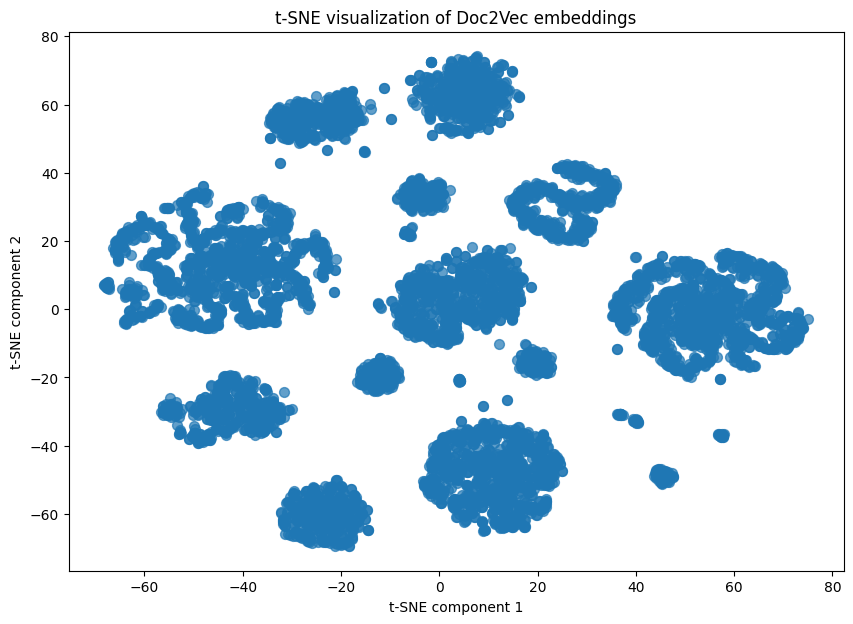

In [ ]:
# Apply t-SNE to the Doc2Vec embeddings
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(train_doc2vec_embeddings)

# Plot the t-SNE results
plt.figure(figsize=(10, 7))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=50, alpha=0.7)
plt.title('t-SNE visualization of Doc2Vec embeddings')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.show()

The t-SNE visualization of the Doc2Vec embeddings shows multiple distinct clusters, indicating effective grouping of similar documents. Tightly packed clusters suggest high intra-cluster similarity, while the variation in cluster sizes points to the presence of both broad and specific topics. Additionally, scattered points away from the main clusters indicate outlier documents, and the spatial arrangement and distances between clusters reflect the level of dissimilarity between different document groups.

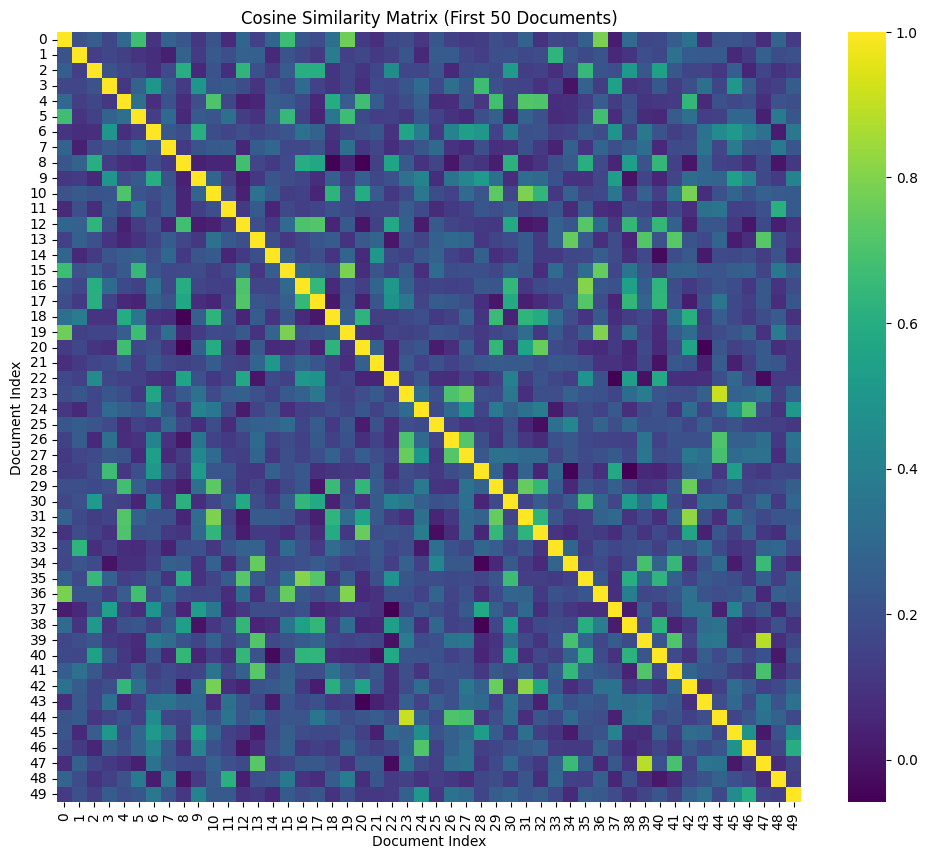

In [ ]:
# Convert the similarity matrix to a DataFrame for better readability
doc2vec_similarity_df = pd.DataFrame(doc2vec_similarity_matrix)

# Plot the heatmap for the first 50 documents
plt.figure(figsize=(12, 10))
sns.heatmap(doc2vec_similarity_df.iloc[:50, :50], cmap='viridis', annot=False)  # Displaying first 50 documents for clarity
plt.title("Cosine Similarity Matrix (First 50 Documents)")
plt.xlabel("Document Index")
plt.ylabel("Document Index")
plt.show()

#### Clustering with K-Means
We will apply K-Means clustering to identify key themes within the Doc2Vec embeddings.

Cluster
0    4056
4    2611
3    1632
1     707
2     587
Name: count, dtype: int64


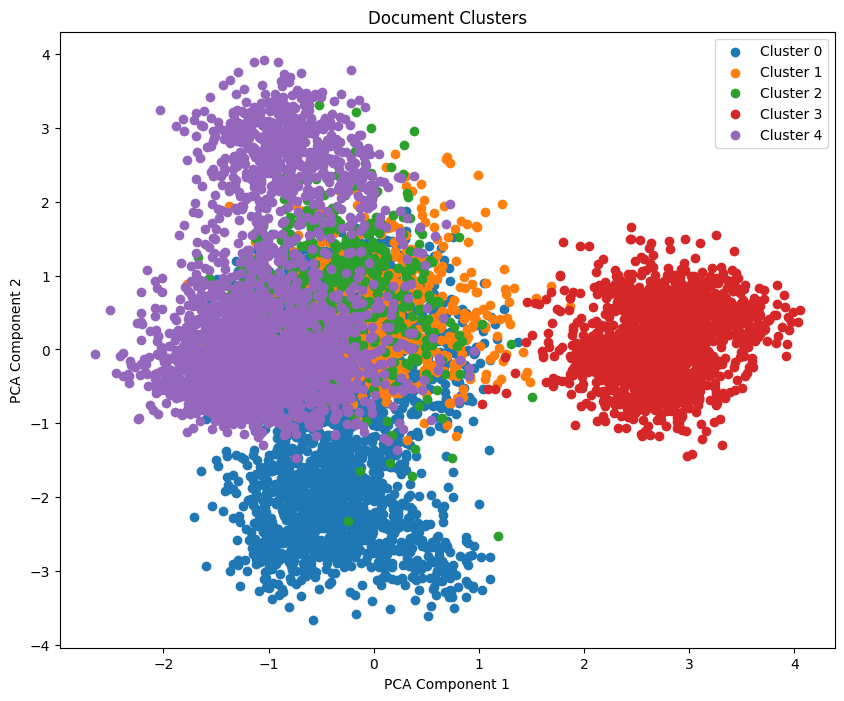

In [ ]:
# Number of clusters
num_clusters = 5

# Perform K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(doc2vec_embeddings)

# Add cluster labels to the dataframe
media_data['Cluster'] = labels

# Print the number of documents in each cluster
print(media_data['Cluster'].value_counts())

# Visualize the clusters using a 2D plot
# Reduce dimensionality to 2D for visualization
pca = PCA(n_components=2, random_state=42)
reduced_embeddings = pca.fit_transform(doc2vec_embeddings)

plt.figure(figsize=(10, 8))
for cluster in range(num_clusters):
    cluster_points = reduced_embeddings[labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')

plt.title('Document Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()


Both t-SNE and PCA visualizations are useful for understanding the structure of Doc2Vec embeddings. The t-SNE plot shows tighter, more distinct clusters, emphasizing intra-cluster similarity and highlighting outliers. In contrast, the PCA plot provides clearer separation for some clusters, particularly Cluster 3, and shows a broader spread of documents within clusters, with some overlap among them. Together, these visualizations offer complementary insights into the document embeddings, with t-SNE emphasizing local structure and PCA providing a more global overview.


### Clusters Analysis

In [ ]:
# Function to get the most common words in a cluster
def get_most_common_words(cluster_num, top_n=10):
    cluster_docs = media_data[media_data['Cluster'] == cluster_num]['content_preprocessed']
    all_words = ' '.join(cluster_docs).split()
    most_common_words = Counter(all_words).most_common(top_n)
    return most_common_words

# Print the most common words in each cluster
for cluster in range(num_clusters):
    print(f"Cluster {cluster}:")
    print(get_most_common_words(cluster))
    print()



Cluster 0:
[('energy', 26232), ('solar', 14016), ('project', 9938), ('power', 8938), ('new', 8894), ('year', 8379), ('gas', 8021), ('company', 7854), ('u', 7562), ('technology', 7528)]

Cluster 1:
[('energy', 4558), ('solar', 2502), ('project', 1915), ('power', 1564), ('new', 1531), ('year', 1352), ('gas', 1347), ('u', 1318), ('technology', 1252), ('company', 1250)]

Cluster 2:
[('energy', 3649), ('solar', 2102), ('project', 1572), ('new', 1378), ('gas', 1241), ('year', 1206), ('company', 1197), ('power', 1172), ('u', 1071), ('technology', 1017)]

Cluster 3:
[('energy', 10704), ('solar', 5734), ('project', 4299), ('new', 3560), ('power', 3469), ('gas', 3362), ('company', 3358), ('year', 3184), ('u', 3120), ('technology', 3004)]

Cluster 4:
[('energy', 17836), ('solar', 9086), ('project', 6728), ('new', 5645), ('gas', 5622), ('year', 5371), ('power', 5352), ('company', 5191), ('u', 4936), ('technology', 4923)]



General Insights:
- Common Themes: All clusters share common themes around energy, solar projects, and technology. This indicates a strong overall focus of the dataset on energy projects and technological advancements in the energy sector.

- Cluster Differentiation: The differentiation among clusters seems to be based on the scale and impact of the projects discussed. For instance, Clusters 3 and 4 appear to cover more comprehensive and higher-impact content, whereas Clusters 1 and 2 might focus on smaller-scale or specific niche projects.

- Business and Technology Focus: Frequent terms like "company" and "technology" across clusters highlight the importance of business activities and technological advancements in the cleantech media landscape.

#### Word Clouds for each cluster:

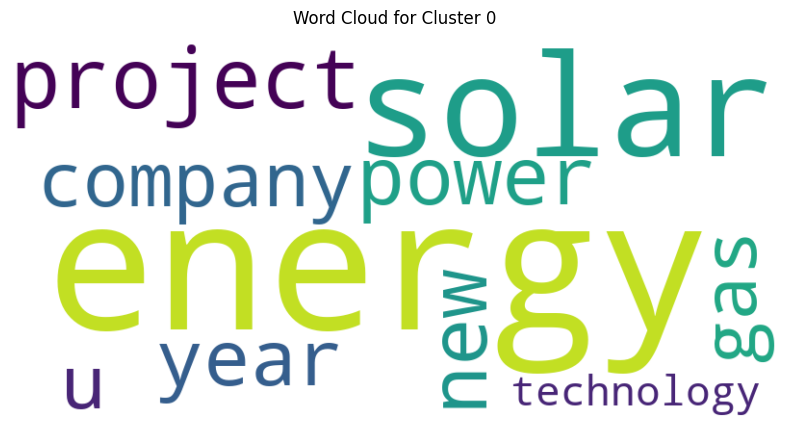

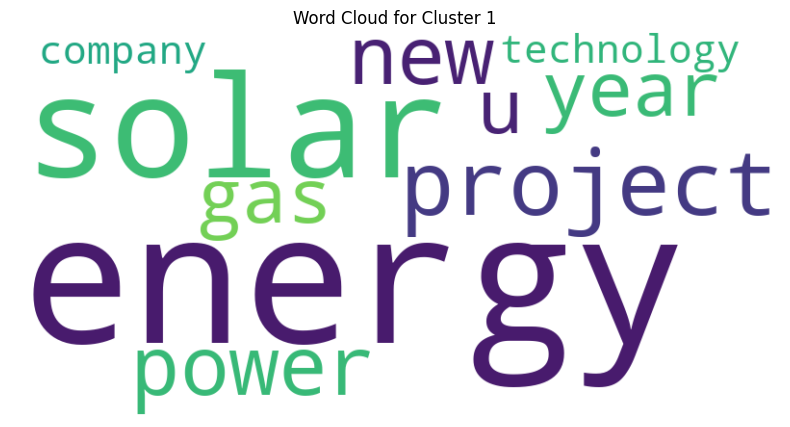

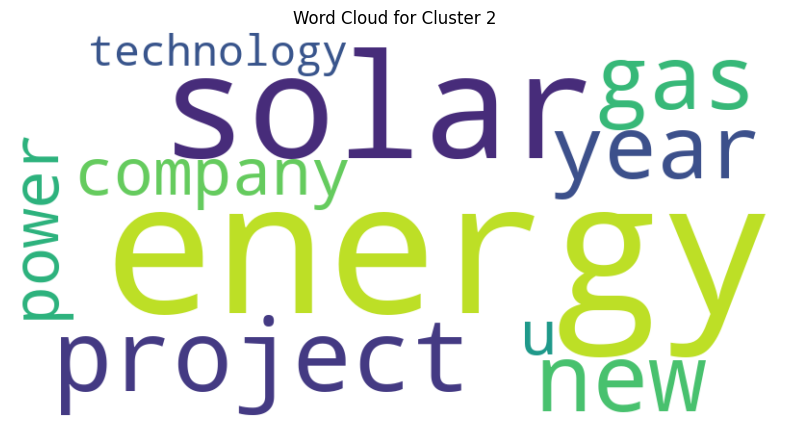

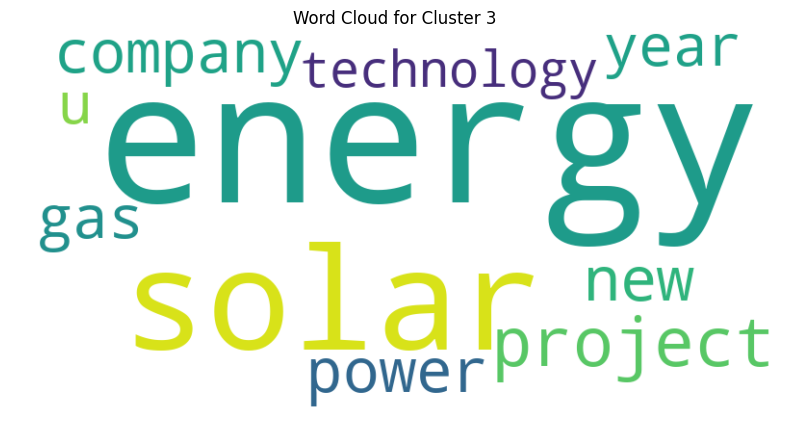

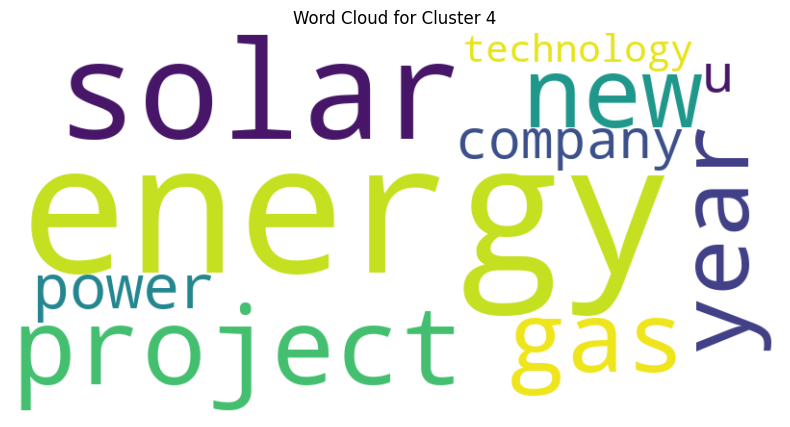

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to generate and display word clouds for each cluster
def plot_word_clouds(cluster_num, words_freq):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(words_freq))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for Cluster {cluster_num}")
    plt.axis('off')
    plt.show()

# Display word clouds for each cluster
for cluster in range(num_clusters):
    common_words = get_most_common_words(cluster)
    plot_word_clouds(cluster, common_words)


### Bar charts for each cluster

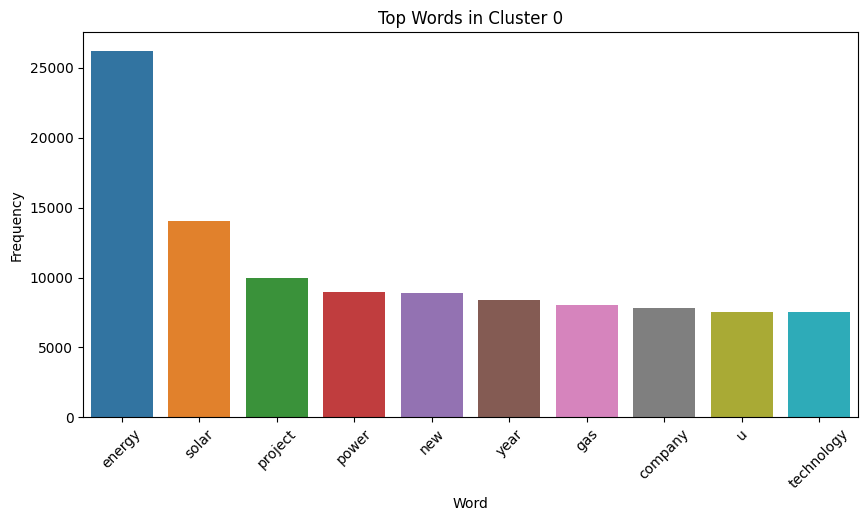

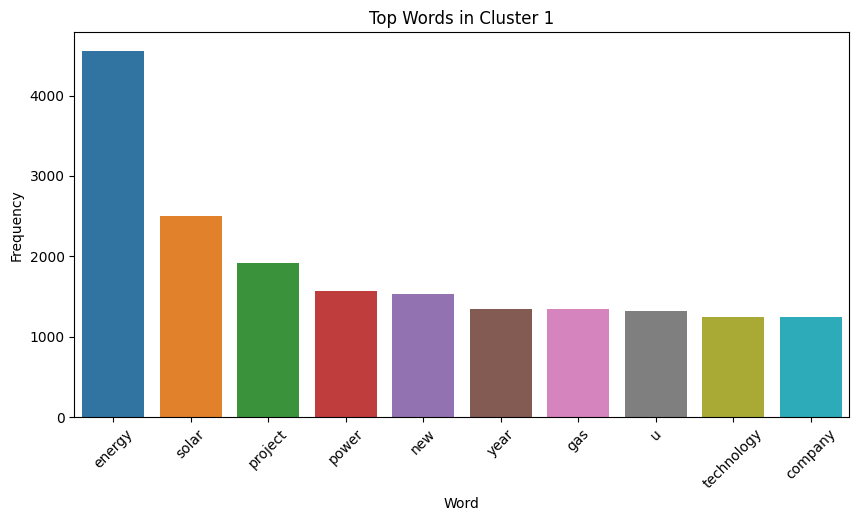

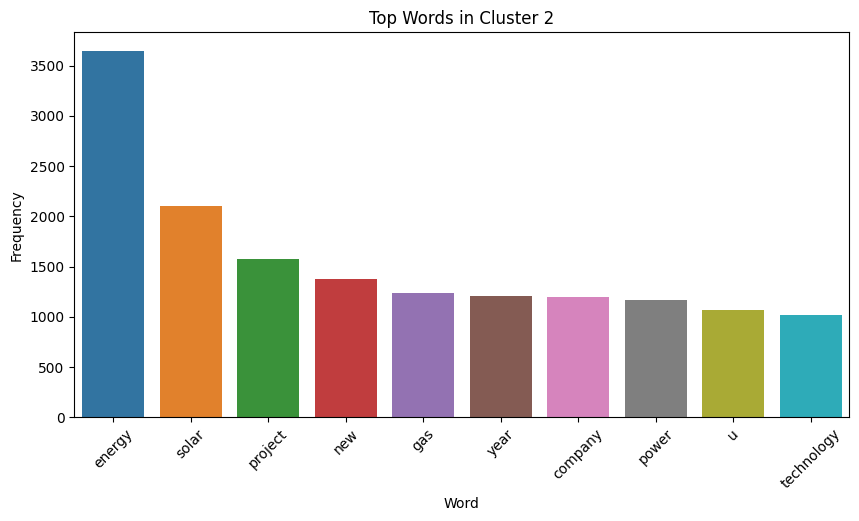

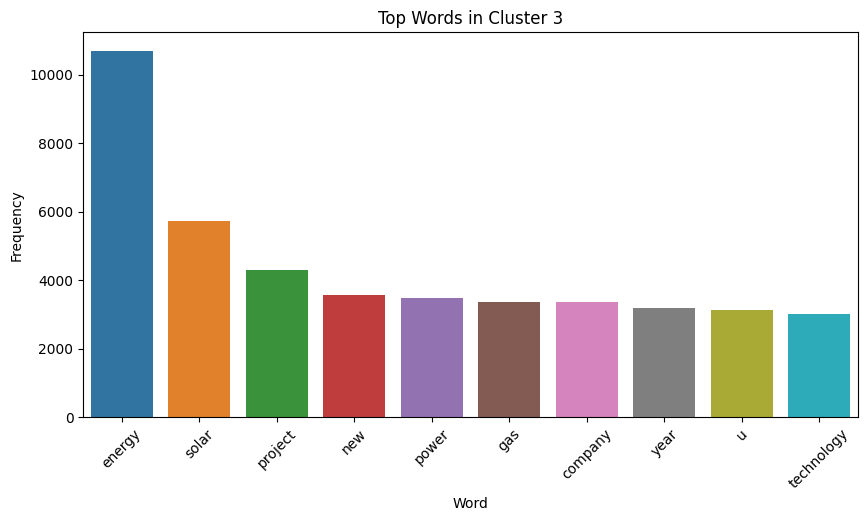

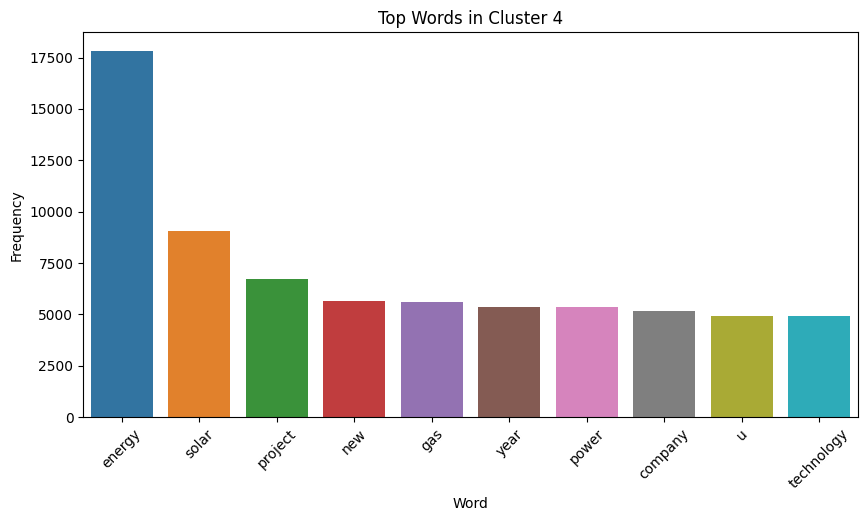

In [ ]:
import seaborn as sns

# Function to generate and display bar charts for each cluster
def plot_bar_charts(cluster_num, words_freq):
    df = pd.DataFrame(words_freq, columns=['Word', 'Frequency'])
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Word', y='Frequency', data=df)
    plt.title(f"Top Words in Cluster {cluster_num}")
    plt.xticks(rotation=45)
    plt.show()

# Display bar charts for each cluster
for cluster in range(num_clusters):
    common_words = get_most_common_words(cluster)
    plot_bar_charts(cluster, common_words)


## **Comparative Analysis of Cleantech Media and Patent Topics**

This section use BERTopic from Stage 1 and Doc2Vec models from Stages to explore the thematic focuses, overlaps, and gaps within the Cleantech Media and Patent datasets. This comparative analysis sheds light on key insights that characterise the relationships and distinctions between these sources.

**Insights from BERTopic Analysis:**

 - Media Dataset (Topic 0 (Geothermal Energy)):

   Keywords: ‘geothermal’, ‘drilling’, ‘heat’, ‘heating’, ‘well’, ‘resource’, ‘project’, ‘development’, ‘source’

- Patent Dataset (Topic 0 (Hydropower)):

  Keywords: ‘hydropower’, ‘station’, ‘water’, ‘level’, ‘conservancy’, ‘method’, ‘dam’, ‘flow’, ‘construction’, ‘gate’


**Insights from Doc2Vec Embedding**
- Media Dataset
Common Topics Across Clusters

Cluster 0:
Top Terms: 'energy', 'solar', 'project', 'power', 'new', 'year', 'gas', 'company', 'u', 'technology'
Cluster 1:
Top Terms: 'energy', 'solar', 'project', 'power', 'new', 'year', 'gas', 'u', 'technology', 'company'
Cluster 2:
Top Terms: 'energy', 'solar', 'project', 'new', 'gas', 'year', 'company', 'power', 'u', 'technology'
Cluster 3:
Top Terms: 'energy', 'solar', 'project', 'new', 'power', 'gas', 'company', 'year', 'u', 'technology'
Cluster 4:
Top Terms: 'energy', 'solar', 'project', 'new', 'gas', 'year', 'power', 'company', 'u', 'technology'



**Key Findings:**

  1.  Thematic Overlaps:
  - Both analyses underscore a strong commitment to renewable energy, with a common emphasis on sustainability and technological innovation. This is evident from the recurrent themes of energy and technology across both datasets.
  2.  Focus on Specific Energies:
  - BERTopic highlights detailed discussions on geothermal energy in media and hydropower in patents, indicating a deep dive into these specific technologies.
  - Doc2Vec reveals a broad media focus on solar energy, suggesting a strong public and media interest in solar technologies, which contrasts with the detailed patent discussions on other energy types.
  3.  Innovation and Development Stages:
  - Media coverage, as shown through Doc2Vec, frequently touches on “new” projects and technologies, particularly solar, indicating a focus on emerging innovations.
  - Patent data, analysed through BERTopic, points to a matured focus on optimizing existing technologies like hydropower, suggesting a difference in the innovation lifecycle focus between the datasets.
  4.  Unique Insights and Gaps:
  - There is a notable innovation gap in media coverage concerning hydropower and geothermal energy, which are well-covered in patent discussions but less so in media.
  -  The media's strong focus on solar energy and the corporate presence in discussions, may influence public perceptions and investment priorities, potentially overshadowing important advancements in other renewable sectors like geothermal and hydropower.

**Conclusion:**

Our analysis utilizes both BERTopic and Doc2Vec to provide a comprehensive overview of the Cleantech Media and Patent datasets. BERTopic is employed for its ability to deliver detailed, context-rich topic identification, which is essential for uncovering specific themes and overlaps within each dataset. This method excels in revealing the nuanced aspects of topic discussions, offering a deep dive into the unique characteristics of each dataset. Conversely, Doc2Vec is used to capture broader themes.

The analysis highlights a complementary yet distinct representation of renewable energy themes in media and patents. Media serves as a catalyst for public interest and discussion, particularly around solar energy, while patents document detailed technological advancements, particularly in hydropower and geothermal energy. Understanding these dynamics is crucial for aligning public engagement with key areas of technological development and addressing the innovation gaps in renewable energy discourse.



